In [1]:
%%capture
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import os
import cortex
import numpy as np
import matplotlib.pyplot as pl
import sys
import yaml
import time
from collections import defaultdict as dd
from scipy.stats import sem, ks_2samp
from statsmodels.stats import weightstats
from sklearn.linear_model import LinearRegression
from nibabel.freesurfer.io import read_morph_data, write_morph_data

opj = os.path.join

sys.path.append("..")

from prfpy.stimulus import PRFStimulus2D
from prfpy.grid import Iso2DGaussianGridder, CSS_Iso2DGaussianGridder, Norm_Iso2DGaussianGridder, DoG_Iso2DGaussianGridder
from prfpy.fit import Iso2DGaussianFitter, Norm_Iso2DGaussianFitter, DoG_Iso2DGaussianFitter, CSS_Iso2DGaussianFitter

from utils.utils import *

In [2]:
#dictionary of results
vis_res = visualize_results()

In [3]:
#load crossvalidated results PSC BOLD fit ABCD norm model variant
space = 'fsnative'

vis_res.main_dict[space]['ABCD_100']['sub-006']['Results'] = combine_results('sub-006', space,
        '/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/CV_results/mean_100_ABCD',
        ['2020-02-05-17-27-16', '2020-02-05-17-37-03', '2020-02-08-11-02-24',
         '2020-02-09-12-55-59', '2020-02-09-20-05-56'],
        '/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/CV_results/sub-006_timecourse-raw_space-fsnative.npy')

In [4]:
%%capture
#load crossvalidated results PSC BOLD fit ABC norm model variant
space = 'fsnative'

vis_res.main_dict[space]['ABC_100']['sub-006']['Results'] = combine_results('sub-006', space,
        '/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/CV_results/mean_100_ABC',
          ['2020-02-10-01-09-28', '2020-02-10-09-12-40', 
         '2020-02-10-09-37-55', '02-10-11-30-44'])

In [5]:
%%capture
#load crossvalidated results PSC BOLD fit ACD norm model variant
space = 'fsnative'

vis_res.main_dict[space]['ACD_100']['sub-006']['Results'] = combine_results('sub-006', space,
        '/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/CV_results/mean_100_ACD',
        ['2020-02-10-17-59-24', '2020-02-11-07-55-07',
         '2020-02-11-14-30-41', '2020-02-12-06-46-13'])

In [4]:
#load crossvalidated results PSC BOLD fit ABCD norm model variant
space = 'T1w'

vis_res.main_dict[space]['ABCD_100']['sub-006']['Results'] = combine_results('sub-006', space,
        '/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/CV_results/mean_100_ABCD_T1w',
        ['2020-02-13-00-14-59', '2020-02-13-23-54-19',
         '2020-02-14-08-28-59', '2020-02-14-19-00-05'],
        ref_img_path='/Users/marcoaqil/Downloads/sub-006_ses-1_task-1R_run-1_space-T1w_desc-brain_mask.nii.gz')

In [5]:
%%capture
#convert results from prfpy outputs to quantities of interest (eccentricity, polar angle, etc)
process_results(vis_res.main_dict, return_norm_profiles=True)
vis_res.subjects = get_subjects(vis_res.main_dict)
vis_res.spaces = vis_res.main_dict.keys()

In [6]:
#transferring Wang 2015 atlas labels from fsaverage to subject (or simply parsing if already transferred)
#set to true to output indices of custom V1V3V3
vis_res.transfer_rois=False
vis_res.output_custom_V1V2V3 = False

fs_dir = '/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/freesurfer'

vis_res.transfer_parse_labels(fs_dir)

In [56]:
#combined and model-specific alphas
#visualize subject-specific ROIs and timeseries stats
vis_res.output_freesurfer_polar_maps = False

#change to ROI name if only want specific ROI cortical plots (e.g. 'custom.V1')
vis_res.only_roi = None

vis_res.plot_rois_cortex = False
vis_res.plot_stats_cortex = False
vis_res.plot_rsq_cortex = True
vis_res.plot_ecc_cortex = False
vis_res.plot_polar_cortex = False
vis_res.plot_size_cortex = False
vis_res.plot_amp_cortex = False
vis_res.plot_css_exp_cortex = False
vis_res.plot_surround_size_cortex = False
vis_res.plot_norm_baselines_cortex = False


vis_res.pycortex_plots()

Started server on port 16074
Started server on port 40266
Stopping server
Stopping server


In [ ]:
#capture pycortex views

js_handle = vis_res.js_handle_norm_baselines
base_str = subj+'_Norm-Neural baseline (B)'

vis_res.save_pycortex_views(js_handle, base_str)

<IPython.core.display.Javascript object>


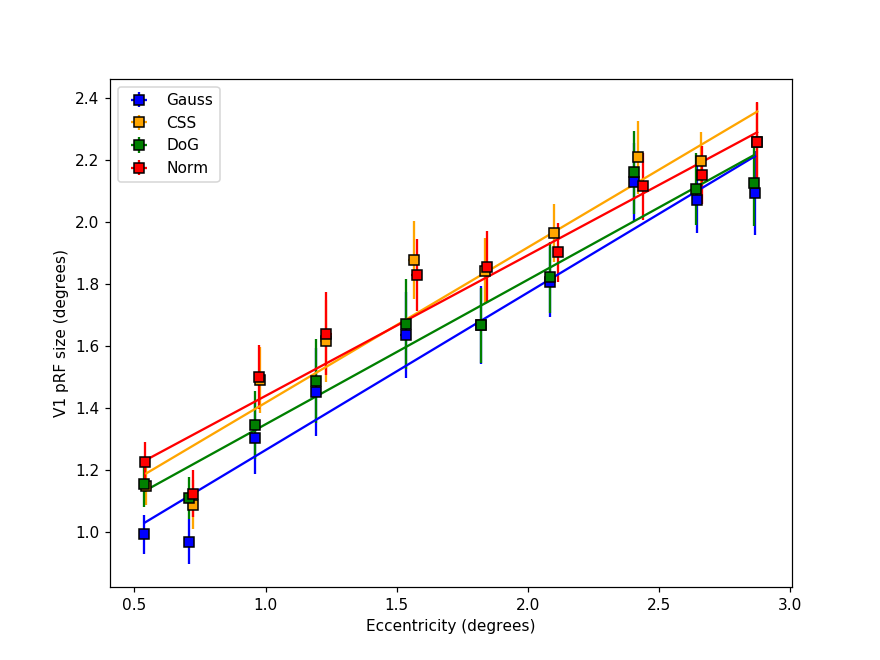

custom.V1 Gauss 0.3657887402840302
custom.V1 CSS 0.3838526665639646
custom.V1 DoG 0.321904569048287
custom.V1 Norm 0.3386705518929686


<IPython.core.display.Javascript object>


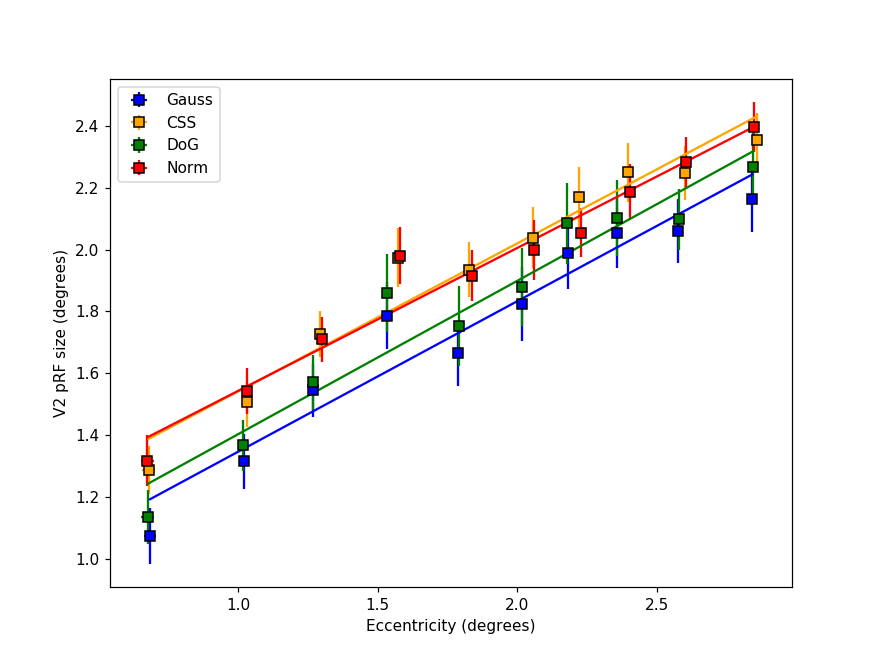

custom.V2 Gauss 0.24282280383218302
custom.V2 CSS 0.2816289086289515
custom.V2 DoG 0.2238815131269496
custom.V2 Norm 0.2876757473443725


<IPython.core.display.Javascript object>


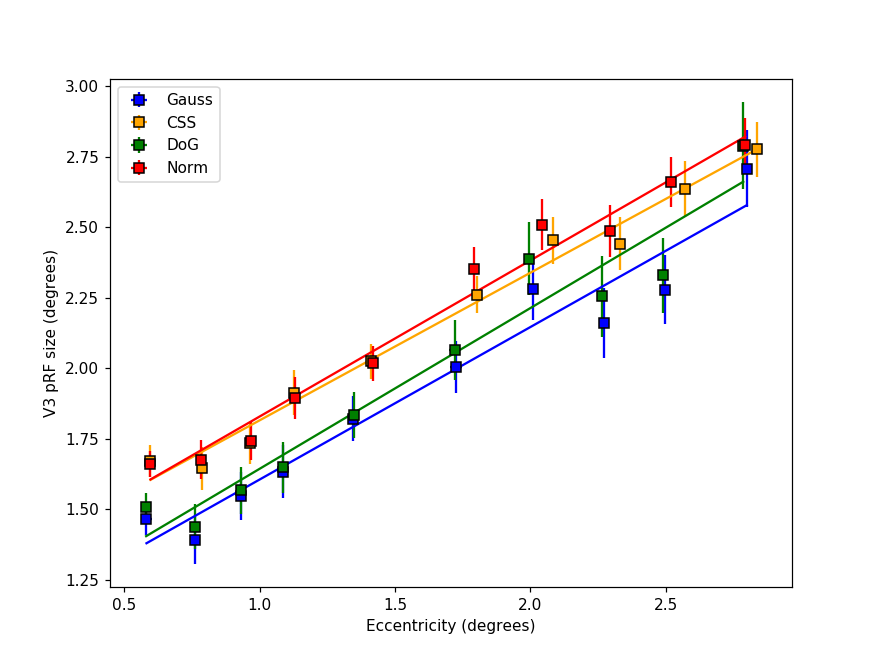

custom.V3 Gauss 0.3419165189579687
custom.V3 CSS 0.41087159238998905
custom.V3 DoG 0.3264799317691365
custom.V3 Norm 0.42888363748910985


<IPython.core.display.Javascript object>


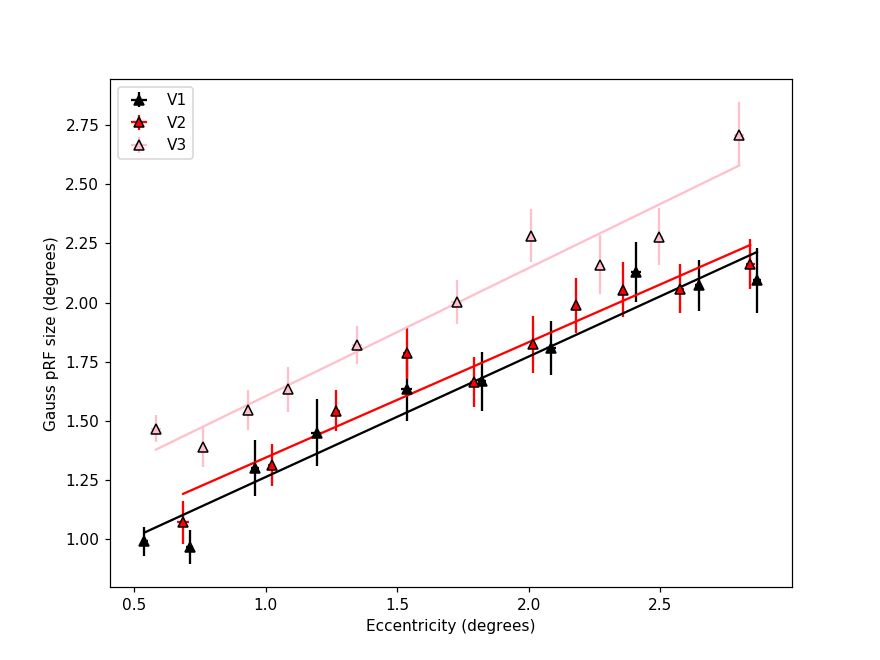

<IPython.core.display.Javascript object>


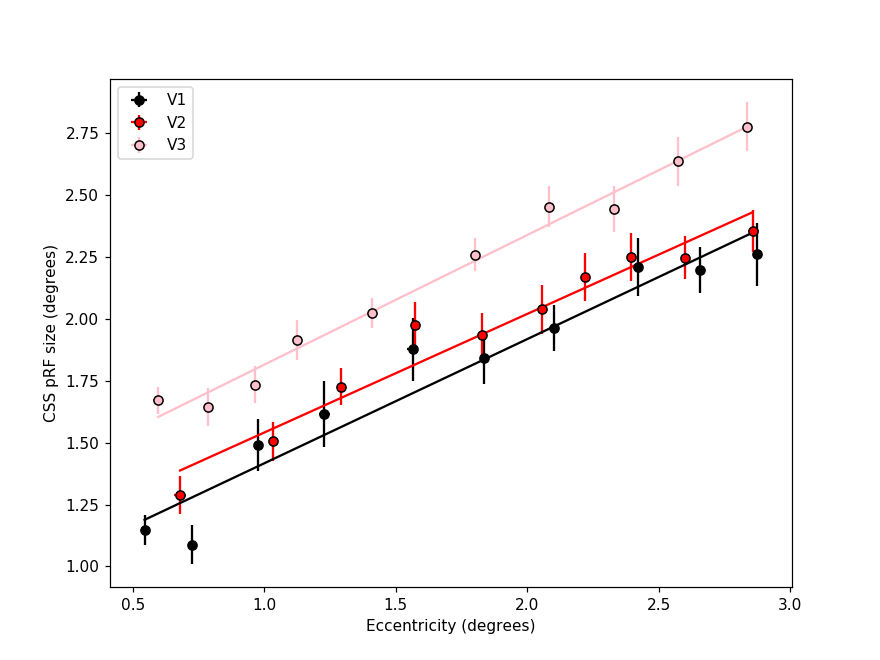

<IPython.core.display.Javascript object>


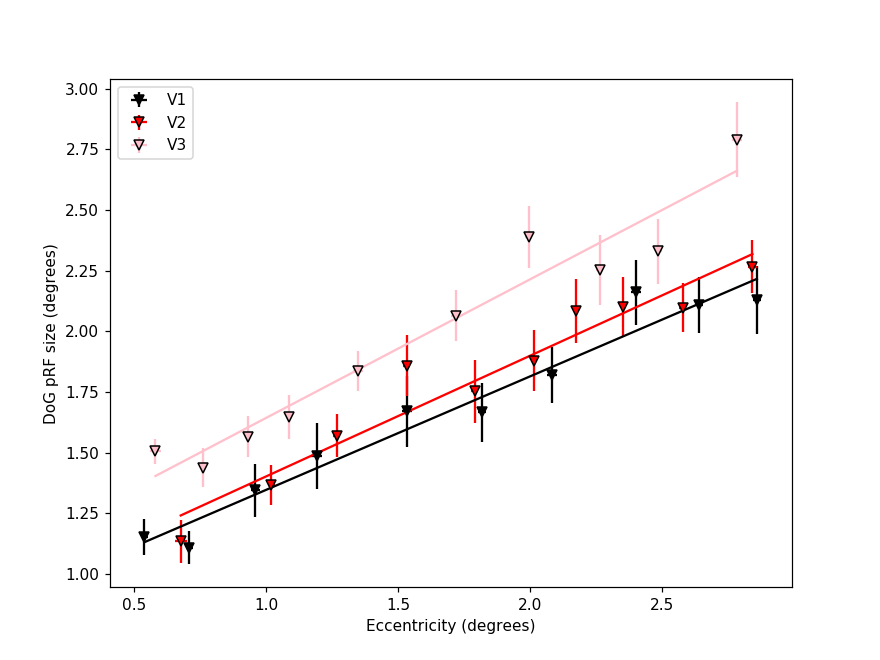

<IPython.core.display.Javascript object>


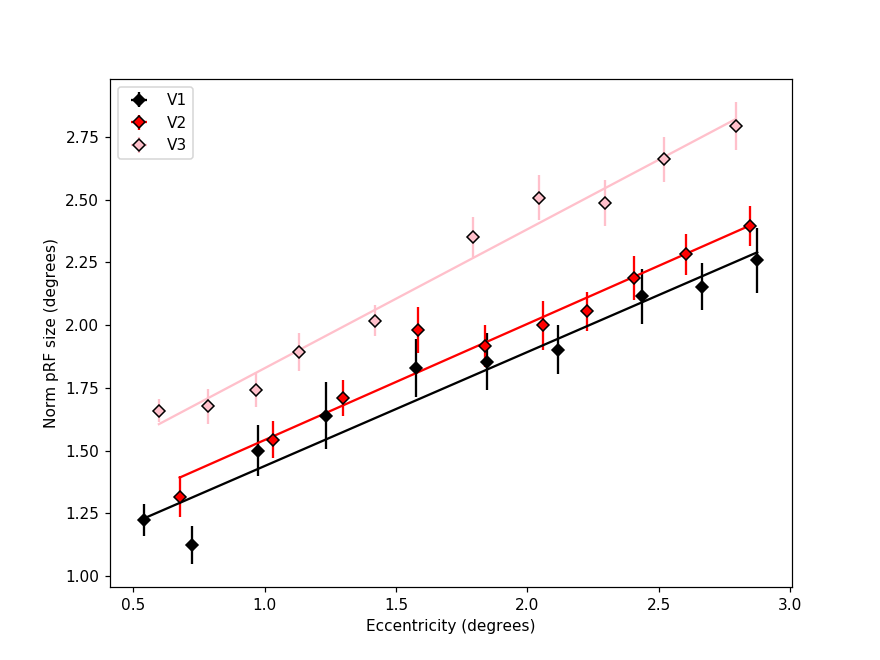

In [129]:
save_figures = False
rsq_thresh = 0.3

pl.rcParams.update({'font.size': 16})
for space, space_res in main_dict.items():
    for analysis, analysis_res in space_res.items():       
        for subj, subj_res in analysis_res.items():

            # binned eccentricity vs other parameters relationships       

            colors = ['blue','orange','green','red']

            fw_hmax_stats = {}
            ecc_stats = {}
            
            ecc = np.vstack(tuple([elem for _,elem in subj_res['Processed results']['Eccentricity'].items()])).T            
            fw_hmax = np.vstack(tuple([elem for _,elem in subj_res['Processed results']['Size (fwhmax)'].items()])).T

            for roi in ['custom.V1', 'custom.V2', 'custom.V3']:#idx_rois:

                pl.figure(roi+' fw_hmax', figsize=(8, 6))
                #pl.title(subj+' '+roi+' - pRF Size VS Eccentricity')

                fw_hmax_stats[roi] = {}
                ecc_stats[roi] = {}
  

                for i, model in enumerate(['Gauss','CSS','DoG','Norm']):
                    fw_hmax_stats[roi][model]=[]
                    ecc_stats[roi][model]=[]

                    #model-specific alpha
                    alpha_roi = roi_mask(idx_rois[subj][roi], subj_res['Processed results']['Alpha'][model])>rsq_thresh    
                    ecc_sorted = np.argsort(ecc[alpha_roi], axis=0)
                    split_ecc_bins = np.array_split(ecc_sorted, 10, axis=0)

                    for ecc_quantile in split_ecc_bins:
                        fw_hmax_stats[roi][model].append(weightstats.DescrStatsW(fw_hmax[alpha_roi,i][ecc_quantile[:,i]],
                                                                              weights=rsq[alpha_roi,i][ecc_quantile[:,i]]))

                        ecc_stats[roi][model].append(weightstats.DescrStatsW(ecc[alpha_roi,i][ecc_quantile[:,i]],
                                                                              weights=rsq[alpha_roi,i][ecc_quantile[:,i]]))



                    WLS = LinearRegression()
                    WLS.fit(ecc[alpha_roi,i].reshape(-1, 1), fw_hmax[alpha_roi,i], sample_weight=rsq[alpha_roi,i])
                    pl.plot([ss.mean for ss in ecc_stats[roi][model]],
                            WLS.predict(np.array([ss.mean for ss in ecc_stats[roi][model]]).reshape(-1, 1)),
                            color=colors[i])

                    print(roi+" "+model+" "+str(WLS.score(ecc[alpha_roi,i].reshape(-1, 1), fw_hmax[alpha_roi,i], sample_weight=rsq[alpha_roi,i])))

                    plot = pl.errorbar([ss.mean for ss in ecc_stats[roi][model]],
                       [ss.mean for ss in fw_hmax_stats[roi][model]],
                       yerr=np.array([np.abs(ss.zconfint_mean(alpha=0.05)-ss.mean) for ss in fw_hmax_stats[roi][model]]).T,
                       xerr=np.array([np.abs(ss.zconfint_mean(alpha=0.05)-ss.mean) for ss in ecc_stats[roi][model]]).T,
                       fmt='s', mfc=colors[i], mec='black', label=model, ecolor=colors[i])

                    pl.xlabel('Eccentricity (degrees)')
                    pl.ylabel(roi.replace('custom.','')+' pRF size (degrees)')
                pl.legend(loc=0)
                if save_figures:
                    pl.savefig('/Users/marcoaqil/PRFMapping/Figures/'+subj+'_'+
                               roi.replace('.','_')+'_fw-hmax.png', dpi=200, bbox_inches='tight')


            # by model

            colors = {}
            colors['custom.V1']= 'black'
            colors['custom.V2']= 'red'
            colors['custom.V3']= 'pink'

            symbol = {}
            symbol['Gauss'] = '^'
            symbol['CSS'] = 'o'
            symbol['DoG'] = 'v'
            symbol['Norm'] = 'D'

            fw_hmax_stats = {}
            ecc_stats = {}

            for roi in colors:#idx_rois:

                fw_hmax_stats[roi] = {}
                ecc_stats[roi] = {}  

                for i, model in enumerate(['Gauss','CSS','DoG','Norm']):

                    pl.figure(model+' fw_hmax', figsize=(8, 6))
                    #pl.title(subj+' - '+model+' pRF Size vs Eccentricity')

                    fw_hmax_stats[roi][model]=[]
                    ecc_stats[roi][model]=[]

                    #model-specific alpha
                    alpha_roi = roi_mask(idx_rois[subj][roi], subj_res['Processed results']['Alpha'][model])>rsq_thresh    
                    ecc_sorted = np.argsort(ecc[alpha_roi], axis=0)
                    split_ecc_bins = np.array_split(ecc_sorted, 10, axis=0)

                    for ecc_quantile in split_ecc_bins:
                        fw_hmax_stats[roi][model].append(weightstats.DescrStatsW(fw_hmax[alpha_roi,i][ecc_quantile[:,i]],
                                                                              weights=rsq[alpha_roi,i][ecc_quantile[:,i]]))

                        ecc_stats[roi][model].append(weightstats.DescrStatsW(ecc[alpha_roi,i][ecc_quantile[:,i]],
                                                                              weights=rsq[alpha_roi,i][ecc_quantile[:,i]]))


                    WLS = LinearRegression()
                    WLS.fit(ecc[alpha_roi,i].reshape(-1, 1), fw_hmax[alpha_roi,i], sample_weight=rsq[alpha_roi,i])

                    pl.plot([ss.mean for ss in ecc_stats[roi][model]],
                            WLS.predict(np.array([ss.mean for ss in ecc_stats[roi][model]]).reshape(-1, 1)),
                            color=colors[roi])

                    #print(roi+" "+model+" "+str(WLS.score(ecc[alpha_roi,i].reshape(-1, 1), fw_hmax[alpha_roi,i], sample_weight=rsq[alpha_roi,i])))

                    plot = pl.errorbar([ss.mean for ss in ecc_stats[roi][model]],
                       [ss.mean for ss in fw_hmax_stats[roi][model]],
                       yerr=np.array([np.abs(ss.zconfint_mean(alpha=0.05)-ss.mean) for ss in fw_hmax_stats[roi][model]]).T,
                       xerr=np.array([np.abs(ss.zconfint_mean(alpha=0.05)-ss.mean) for ss in ecc_stats[roi][model]]).T,
                       fmt=symbol[model], mfc=colors[roi], mec='black', label=roi.replace('custom.',''), ecolor=colors[roi])

                    pl.xlabel('Eccentricity (degrees)')
                    pl.ylabel(model+' pRF size (degrees)')

                    pl.legend(loc=0)
                    if save_figures:
                        pl.savefig('/Users/marcoaqil/PRFMapping/Figures/'+subj+'_'+
                               model+'_fw-hmax.png', dpi=200, bbox_inches='tight')





<IPython.core.display.Javascript object>


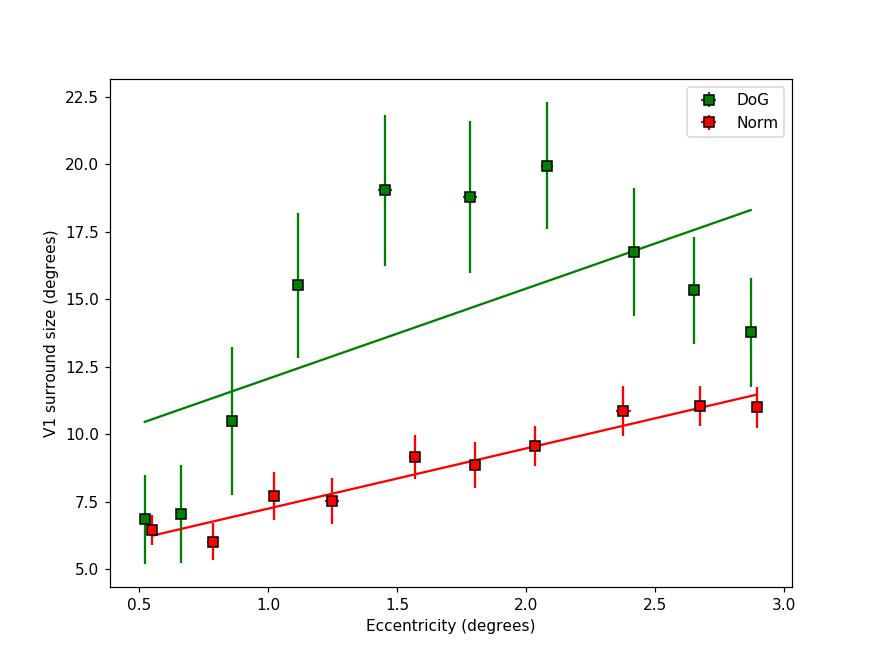

custom.V1 DoG 0.07558777899465939
custom.V1 Norm 0.24776116775174772


<IPython.core.display.Javascript object>


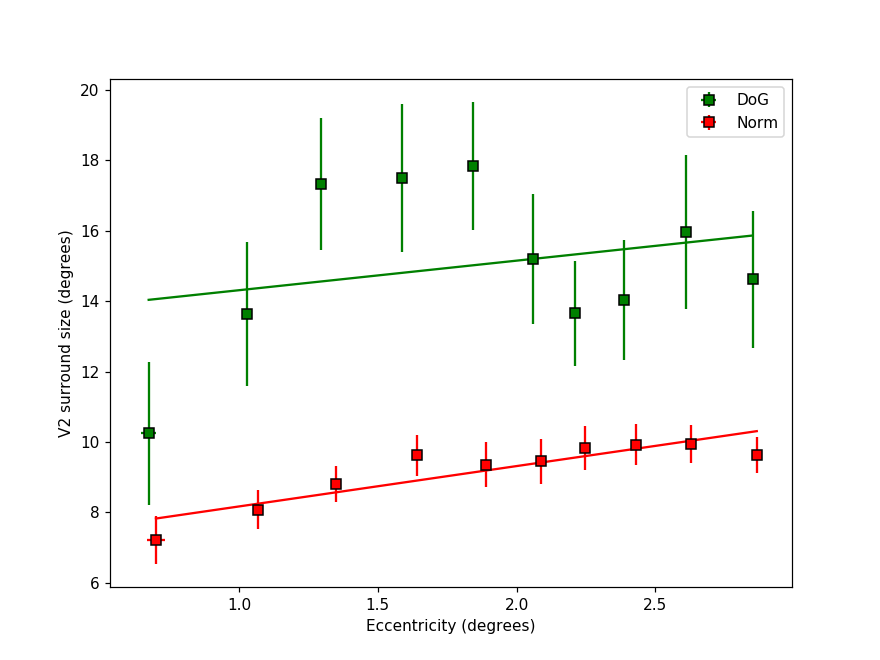

custom.V2 DoG 0.0036436118911126196
custom.V2 Norm 0.06398963781241851


<IPython.core.display.Javascript object>


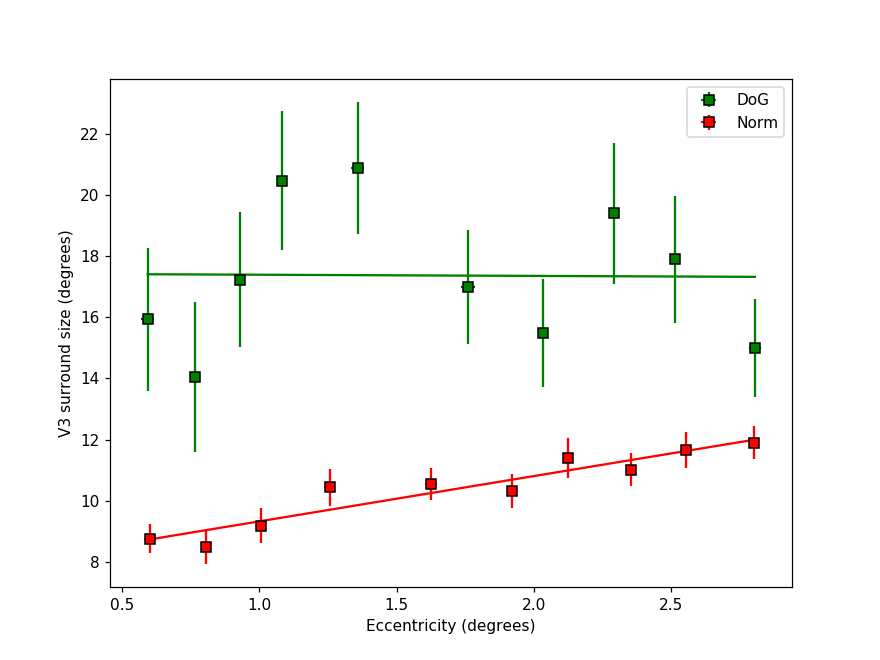

custom.V3 DoG 8.47024864680801e-06
custom.V3 Norm 0.12080086391464939


<IPython.core.display.Javascript object>


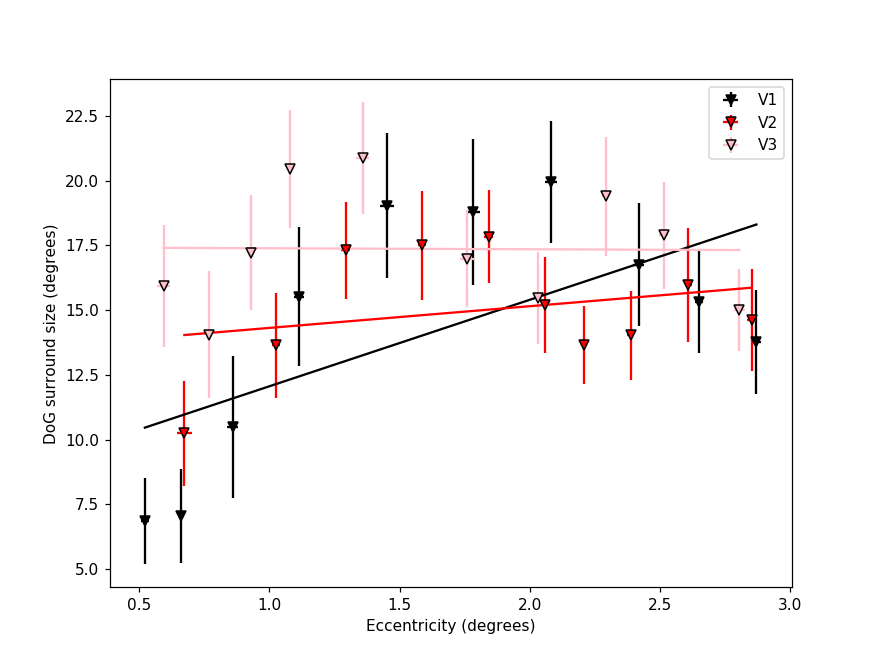

<IPython.core.display.Javascript object>


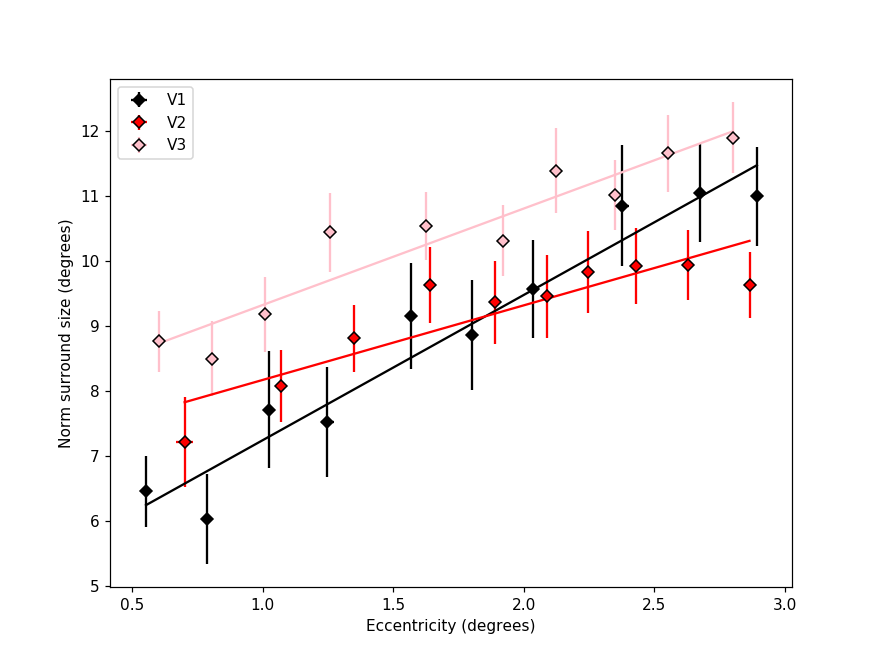

In [130]:
# binned eccentricity vs other parameters relationships

for space, space_res in main_dict.items():
    for analysis, analysis_res in space_res.items():       
        for subj, subj_res in analysis_res.items():

            colors = {}
            colors['DoG'] = 'green'
            colors['Norm'] = 'red'

            fw_atmin_stats = {}
            ecc_stats = {}
            
            ecc = np.vstack(tuple([elem for _,elem in subj_res['Processed results']['Eccentricity'].items()])).T            
            fw_atmin = np.vstack(tuple([elem for _,elem in subj_res['Processed results']['Surround Size (fwatmin)'].items()])).T

            for roi in ['custom.V1', 'custom.V2', 'custom.V3']:#idx_rois:

                pl.figure(roi+" fw_atmin", figsize=(8, 6))

                #pl.title(subj+' '+roi+" - Surround Size vs Eccentricity")

                fw_atmin_stats[roi] = {}
                ecc_stats[roi] = {}  

                for i, model in enumerate(['DoG','Norm']):

                    #hacky. stop using arrays and use dictionaries to distinguish models instead
                    i+=2

                    fw_atmin_stats[roi][model]=[]
                    ecc_stats[roi][model]=[]

                    #model-specific alpha
                    alpha_roi = (roi_mask(idx_rois[subj][roi], subj_res['Processed results']['Alpha'][model])>rsq_thresh) * (fw_atmin[:,i-2]<w_max)
                    ecc_sorted = np.argsort(ecc[alpha_roi], axis=0)
                    split_ecc_bins = np.array_split(ecc_sorted, 10, axis=0)

                    for ecc_quantile in split_ecc_bins:
                        fw_atmin_stats[roi][model].append(weightstats.DescrStatsW(fw_atmin[alpha_roi,i-2][ecc_quantile[:,i]],
                                                                              weights=rsq[alpha_roi,i][ecc_quantile[:,i]]))

                        ecc_stats[roi][model].append(weightstats.DescrStatsW(ecc[alpha_roi,i][ecc_quantile[:,i]],
                                                                              weights=rsq[alpha_roi,i][ecc_quantile[:,i]]))



                    WLS = LinearRegression()
                    WLS.fit(ecc[alpha_roi,i].reshape(-1, 1), fw_atmin[alpha_roi,i-2], sample_weight=rsq[alpha_roi,i])
                    pl.plot([ss.mean for ss in ecc_stats[roi][model]],
                            WLS.predict(np.array([ss.mean for ss in ecc_stats[roi][model]]).reshape(-1, 1)),
                           color=colors[model])

                    print(roi+" "+model+" "+str(WLS.score(ecc[alpha_roi,i].reshape(-1, 1), fw_atmin[alpha_roi, i-2], sample_weight=rsq[alpha_roi,i])))

                    plot = pl.errorbar([ss.mean for ss in ecc_stats[roi][model]],
                       [ss.mean for ss in fw_atmin_stats[roi][model]],
                       yerr=np.array([np.abs(ss.zconfint_mean(alpha=0.05)-ss.mean) for ss in fw_atmin_stats[roi][model]]).T,
                       xerr=np.array([np.abs(ss.zconfint_mean(alpha=0.05)-ss.mean) for ss in ecc_stats[roi][model]]).T,
                       fmt='s', mfc=colors[model], mec='black', label=model, ecolor=colors[model])

                    pl.xlabel('Eccentricity (degrees)')
                    pl.ylabel(roi.replace('custom.','')+' surround size (degrees)')

                pl.legend(loc=0)
                if save_figures:
                    pl.savefig('/Users/marcoaqil/PRFMapping/Figures/'+subj+'_'+
                               roi.replace('.','_')+'_fw-atmin.png', dpi=200, bbox_inches='tight')


            # by model
            colors = {}
            colors['custom.V1']= 'black'
            colors['custom.V2']= 'red'
            colors['custom.V3']= 'pink'

            symbol = {}
            symbol['Gauss'] = 's'
            symbol['CSS'] = 'o'
            symbol['DoG'] = 'v'
            symbol['Norm'] = 'D'

            fw_atmin_stats = {}
            ecc_stats = {}

            for roi in colors:#idx_rois:

                fw_atmin_stats[roi] = {}
                ecc_stats[roi] = {}


                for i, model in enumerate(['DoG','Norm']):

                    #HACKY. stop using arrays and use dictionaries to distinguish models instead
                    i+=2

                    pl.figure(model+" fw_atmin", figsize=(8, 6))

                    fw_atmin_stats[roi][model]=[]
                    ecc_stats[roi][model]=[]

                    #model-specific alpha
                    alpha_roi = (roi_mask(idx_rois[subj][roi], subj_res['Processed results']['Alpha'][model])>rsq_thresh) * (fw_atmin[:,i-2]<w_max)


                    ecc_sorted = np.argsort(ecc[alpha_roi], axis=0)
                    split_ecc_bins = np.array_split(ecc_sorted, 10, axis=0)


                    for ecc_quantile in split_ecc_bins:
                        fw_atmin_stats[roi][model].append(weightstats.DescrStatsW(fw_atmin[alpha_roi,i-2][ecc_quantile[:,i]],
                                                                              weights=rsq[alpha_roi,i][ecc_quantile[:,i]]))

                        ecc_stats[roi][model].append(weightstats.DescrStatsW(ecc[alpha_roi,i][ecc_quantile[:,i]],
                                                                              weights=rsq[alpha_roi,i][ecc_quantile[:,i]]))



                    WLS = LinearRegression()
                    WLS.fit(ecc[alpha_roi,i].reshape(-1, 1), fw_atmin[alpha_roi,i-2], sample_weight=rsq[alpha_roi,i])
                    pl.plot([ss.mean for ss in ecc_stats[roi][model]],
                            WLS.predict(np.array([ss.mean for ss in ecc_stats[roi][model]]).reshape(-1, 1)),
                           color=colors[roi])

                    #print(roi+" "+model+" "+str(WLS.score(ecc[alpha_roi,i].reshape(-1, 1), fw_atmin[alpha_roi,i], sample_weight=rsq[alpha_roi,i])))

                    plot = pl.errorbar([ss.mean for ss in ecc_stats[roi][model]],
                       [ss.mean for ss in fw_atmin_stats[roi][model]],
                       yerr=np.array([np.abs(ss.zconfint_mean(alpha=0.05)-ss.mean) for ss in fw_atmin_stats[roi][model]]).T,
                       xerr=np.array([np.abs(ss.zconfint_mean(alpha=0.05)-ss.mean) for ss in ecc_stats[roi][model]]).T,
                       fmt=symbol[model], mfc=colors[roi], mec='black', label=roi.replace('custom.',''), ecolor=colors[roi])

                    pl.xlabel('Eccentricity (degrees)')
                    pl.ylabel(model+' surround size (degrees)')

                    pl.legend(loc=0)
                    if save_figures:
                        pl.savefig('/Users/marcoaqil/PRFMapping/Figures/'+subj+'_'+
                               model+'_fw-atmin.png', dpi=200, bbox_inches='tight')





<IPython.core.display.Javascript object>


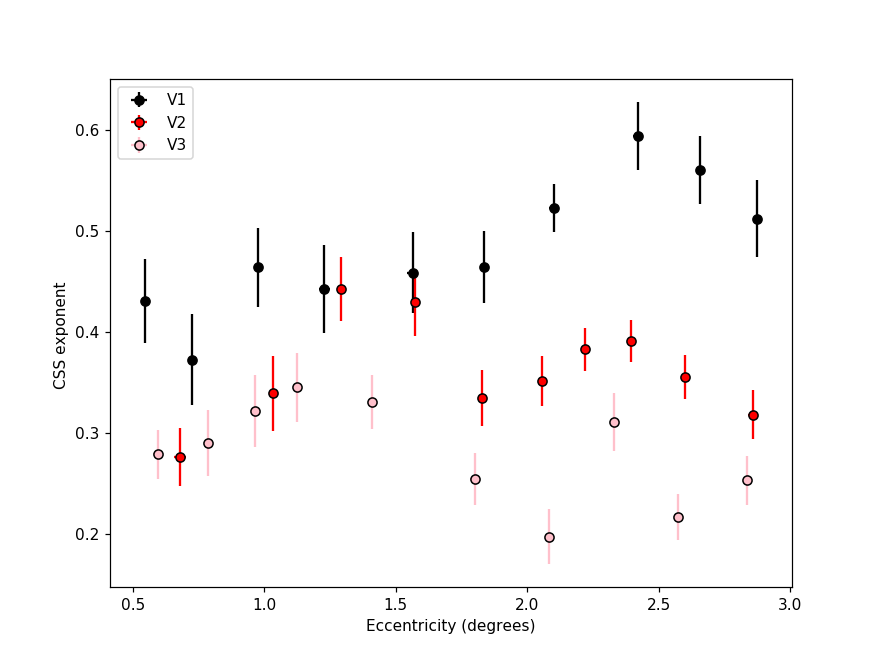

In [131]:
# binned eccentricity vs other parameters relationships
for space, space_res in main_dict.items():
    for analysis, analysis_res in space_res.items():       
        for subj, subj_res in analysis_res.items():
            colors = {}
            colors['custom.V1']= 'black'
            colors['custom.V2']= 'red'
            colors['custom.V3']= 'pink'

            symbol = {}
            symbol['CSS exponent'] = 'o'

            css_exp_stats = {}
            ecc_stats = {}
            
            ecc = np.vstack(tuple([elem for _,elem in subj_res['Processed results']['Eccentricity'].items()])).T            
            css_exp = subj_res['Processed results']['CSS Exponent']['CSS']

            for roi in colors:#idx_rois:

                css_exp_stats[roi] = {}
                ecc_stats[roi] = {}

                alpha_roi = (roi_mask(idx_rois[subj][roi], subj_res['Processed results']['Alpha']['CSS'])>rsq_thresh)

                if alpha_roi.sum()>40:    

                    ecc_sorted = np.argsort(ecc[alpha_roi], axis=0)
                    split_ecc_bins = np.array_split(ecc_sorted, 10, axis=0)

                    #note: here i indexes different params of same model (above it is same param in different models)
                    #therefore ecc_stats is the same for all params
                    for i, param in enumerate(symbol):
                        pl.figure(param, figsize=(8, 6))
                        #pl.title(subj+' - '+param)

                        css_exp_stats[roi][param]=[]
                        ecc_stats[roi][param]=[]

                        for ecc_quantile in split_ecc_bins:
                            css_exp_stats[roi][param].append(weightstats.DescrStatsW(css_exp[alpha_roi][ecc_quantile[:,1]],
                                                                                  weights=rsq[alpha_roi,1][ecc_quantile[:,1]]))

                            ecc_stats[roi][param].append(weightstats.DescrStatsW(ecc[alpha_roi,1][ecc_quantile[:,1]],
                                                                                  weights=rsq[alpha_roi,1][ecc_quantile[:,1]]))




                        plot = pl.errorbar([ss.mean for ss in ecc_stats[roi][param]],
                           [ss.mean for ss in css_exp_stats[roi][param]],
                           yerr=np.array([np.abs(ss.zconfint_mean(alpha=0.05)-ss.mean) for ss in css_exp_stats[roi][param]]).T,
                           xerr=np.array([np.abs(ss.zconfint_mean(alpha=0.05)-ss.mean) for ss in ecc_stats[roi][param]]).T,
                           fmt=symbol[param], mfc=colors[roi], mec='black', label=roi.replace('custom.',''), ecolor=colors[roi])
                        #pl.yscale('log')
                        pl.legend(loc=2)
                        pl.xlabel('Eccentricity (degrees)')
                        pl.ylabel('CSS exponent ')
                else:
                    print(roi+" has no vertices/voxels above specified rsq threshold")


            if save_figures:
                pl.savefig('/Users/marcoaqil/PRFMapping/Figures/'+subj+'_'+
                               'CSS-exponent.png', dpi=200, bbox_inches='tight')    


<IPython.core.display.Javascript object>


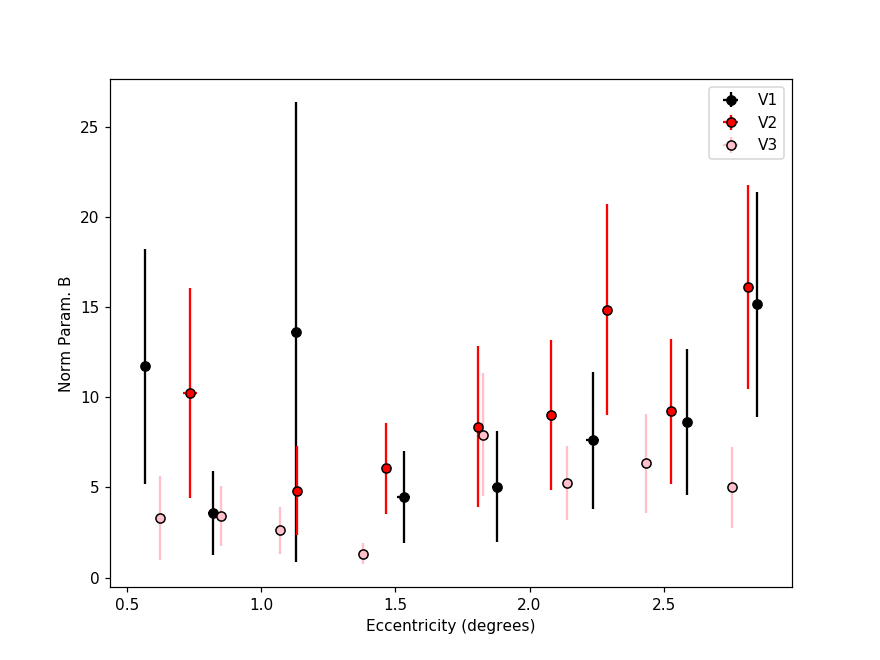

<IPython.core.display.Javascript object>


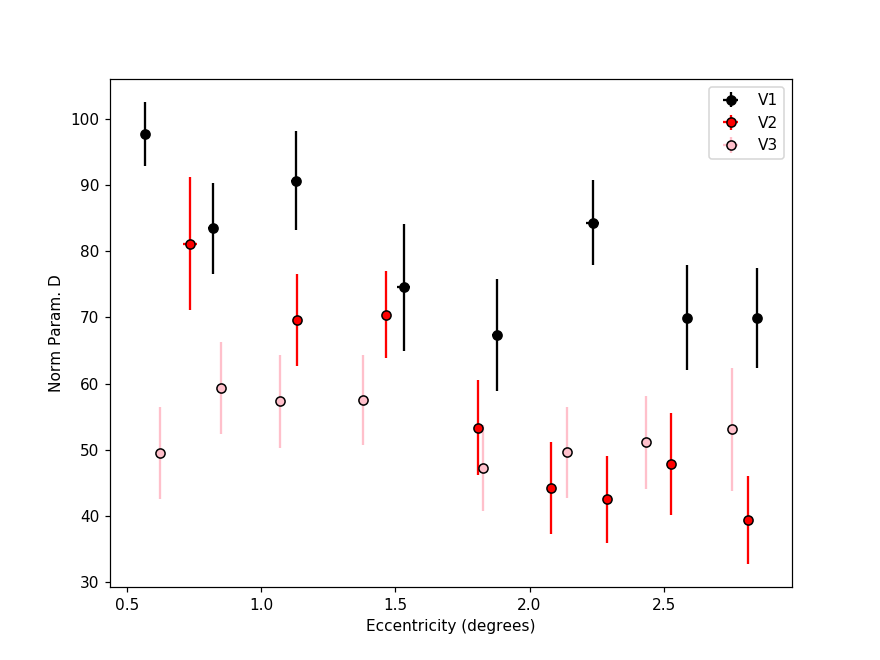

<IPython.core.display.Javascript object>


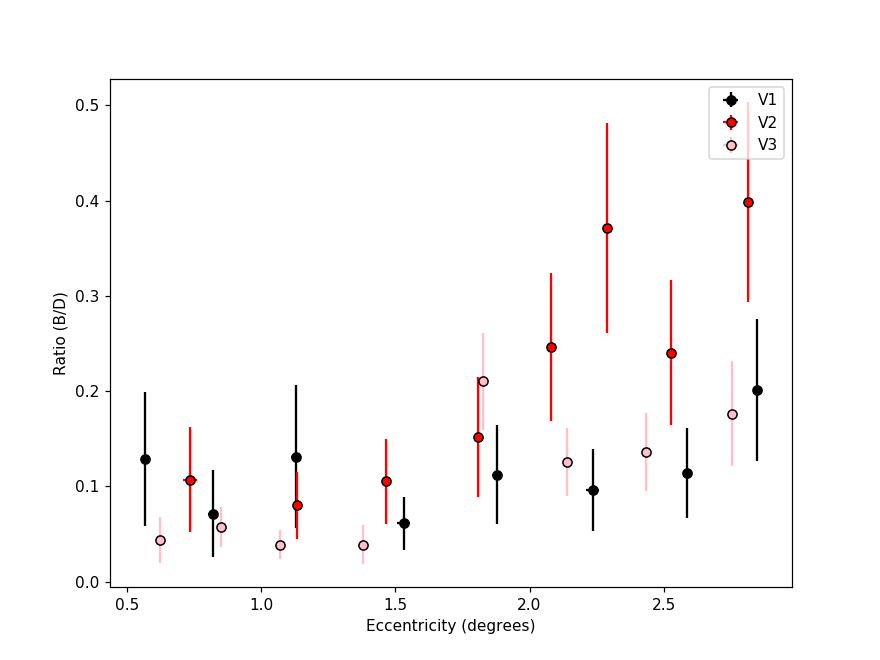

In [198]:
# binned eccentricity vs other parameters relationships
rsq_thresh = 0.3
for space, space_res in main_dict.items():
    for analysis, analysis_res in space_res.items():       
        for subj, subj_res in analysis_res.items():
            colors = {}
            colors['custom.V1']= 'black'
            colors['custom.V2']= 'red'
            colors['custom.V3']= 'pink'

            symbol = {}
            symbol['Norm Param. B'] = 'o'
            symbol['Norm Param. D'] = 'o'
            symbol['Ratio (B/D)'] = 'o'

            baselines_stats = {}
            ecc_stats = {}

            ecc = np.vstack(tuple([elem for _,elem in subj_res['Processed results']['Eccentricity'].items()])).T            
            baselines = np.vstack(tuple([subj_res['Processed results'][key]['Norm'] for key in symbol])).T

            
            for roi in colors:#idx_rois:

                baselines_stats[roi] = {}
                ecc_stats[roi] = {}

                alpha_roi = (roi_mask(idx_rois[subj][roi], subj_res['Processed results']['Alpha']['Norm'])>rsq_thresh)
                
                if alpha_roi.sum()>40:    

                    ecc_sorted = np.argsort(ecc[alpha_roi], axis=0)
                    split_ecc_bins = np.array_split(ecc_sorted, 8, axis=0)

                    #note: here i indexes different params of same model (above it is same param in different models)
                    #therefore ecc_stats is the same for all params
                    for i, param in enumerate(symbol):
                        pl.figure(param, figsize=(8, 6))

                        #pl.title(subj+' - '+param+' vs Eccentricity')

                        baselines_stats[roi][param]=[]
                        ecc_stats[roi][param]=[]

                        for ecc_quantile in split_ecc_bins:
                            baselines_stats[roi][param].append(weightstats.DescrStatsW(baselines[alpha_roi,i][ecc_quantile[:,3]],
                                                                                  weights=rsq[alpha_roi,3][ecc_quantile[:,3]]))

                            ecc_stats[roi][param].append(weightstats.DescrStatsW(ecc[alpha_roi,3][ecc_quantile[:,3]],
                                                                                  weights=rsq[alpha_roi,3][ecc_quantile[:,3]]))




                        plot = pl.errorbar([ss.mean for ss in ecc_stats[roi][param]],
                           [ss.mean for ss in baselines_stats[roi][param]],
                           yerr=np.array([np.abs(ss.zconfint_mean(alpha=0.05)-ss.mean) for ss in baselines_stats[roi][param]]).T,
                           xerr=np.array([np.abs(ss.zconfint_mean(alpha=0.05)-ss.mean) for ss in ecc_stats[roi][param]]).T,
                           fmt=symbol[param], mfc=colors[roi], mec='black', label=roi.replace('custom.',''), ecolor=colors[roi])
                        #pl.yscale('log')
                        pl.legend(loc=0)

                        pl.xlabel('Eccentricity (degrees)')
                        pl.ylabel(param)
                        if save_figures:
                            pl.savefig('/Users/marcoaqil/PRFMapping/Figures/'+subj+'_'+
                               param.replace("/","").replace('.','').replace(' ','_')+'.png', dpi=200, bbox_inches='tight')

                else:
                    print(roi+" has no vertices/voxels above specified rsq threshold")




In [ ]:
# binned fw_hmax vs other parameters relationships
rsq_thresh = 0.3

colors = {}
colors['custom.V1']= 'black'
colors['custom.V2']= 'red'
colors['custom.V3']= 'pink'

symbol = {}
symbol['Norm. param. B'] = 'o'
symbol['Norm. param. D'] = 'o'
symbol['Ratio (B/D)'] = 'o'
symbol['(A+B)/(C+D)'] = 'o'
symbol['(AD-BC)'] = 'o'


baselines_stats = {}
fw_hmax_stats = {}

for roi in colors:#idx_rois:
    
    baselines_stats[roi] = {}
    fw_hmax_stats[roi] = {}
    
    alpha_roi = (roi_mask(idx_rois[roi],alpha_norm)>rsq_thresh) * (fw_atmin[:,1]<w_max)
    if alpha_roi.sum()>40:    
    
        fw_hmax_sorted = np.argsort(fw_hmax[alpha_roi], axis=0)
        split_fw_hmax_bins = np.array_split(fw_hmax_sorted, 10, axis=0)

        #note: here i indexes different params of same model (above it is same param in different models)
        #therefore fw_hmax_stats is the same for all params
        for i, param in enumerate(symbol):
            pl.figure("fwhmax vs "+param, figsize=(8, 6))
            #pl.title(subj+' - '+param+' vs pRF size (FWHM)')
            
            baselines_stats[roi][param]=[]
            fw_hmax_stats[roi][param]=[]

            for fw_hmax_quantile in split_fw_hmax_bins:
                baselines_stats[roi][param].append(weightstats.DescrStatsW(baselines[alpha_roi,i][fw_hmax_quantile[:,3]],
                                                                      weights=rsq[alpha_roi,3][fw_hmax_quantile[:,3]]))

                fw_hmax_stats[roi][param].append(weightstats.DescrStatsW(fw_hmax[alpha_roi,3][fw_hmax_quantile[:,3]],
                                                                      weights=rsq[alpha_roi,3][fw_hmax_quantile[:,3]]))




            plot = pl.errorbar([ss.mean for ss in fw_hmax_stats[roi][param]],
               [ss.mean for ss in baselines_stats[roi][param]],
               yerr=np.array([np.abs(ss.zconfint_mean(alpha=0.05)-ss.mean) for ss in baselines_stats[roi][param]]).T,
               xerr=np.array([np.abs(ss.zconfint_mean(alpha=0.05)-ss.mean) for ss in fw_hmax_stats[roi][param]]).T,
               fmt=symbol[param], mfc=colors[roi], mec='black', label=roi.replace('custom.',''), ecolor=colors[roi])
            
            #pl.plot([ss.mean for ss in fw_hmax_stats[roi][param]],0.1*np.array([ss.mean for ss in fw_hmax_stats[roi][param]])**2)
            #pl.yscale('log')
            pl.legend(loc=0)
            pl.xlabel('pRF size (degrees)')
            pl.ylabel(param)
            
            #pl.savefig('/Users/marcoaqil/PRFMapping/Figures/'+subj+'_Norm-'+
            #       param.replace("/","").replace('.','').replace(' ','_')+'-vs-fw_hmax.png', dpi=200, bbox_inches='tight')
    else:
        print(roi+" has no vertices/voxels above specified rsq threshold")
    
    
    

In [ ]:
# binned fw_atmin vs other parameters relationships
rsq_thresh = 0.3

colors = {}
colors['custom.V1']= 'black'
colors['custom.V2']= 'red'
colors['custom.V3']= 'pink'

symbol = {}
symbol['Norm. param. B'] = 'o'
symbol['Norm. param. D'] = 'o'
symbol['Ratio (B/D)'] = 'o'
symbol['(A+B)/(C+D)'] = 'o'
symbol['(AD-BC)'] = 'o'


baselines_stats = {}
fw_atmin_stats = {}

for roi in colors:#idx_rois:
    
    baselines_stats[roi] = {}
    fw_atmin_stats[roi] = {}
    
    alpha_roi = (roi_mask(idx_rois[roi],alpha_norm)>rsq_thresh) * (fw_atmin[:,1]<w_max)
    if alpha_roi.sum()>40:    
    
        fw_atmin_sorted = np.argsort(fw_atmin[alpha_roi], axis=0)
        split_fw_atmin_bins = np.array_split(fw_atmin_sorted, 10, axis=0)

        #NOTE: here i indexes different params of same model (above it is same param in different models)
        #therefore fw_atmin_stats is the same for all params
        for i, param in enumerate(symbol):
            pl.figure("fw_atmin vs "+param, figsize=(8, 6))
            #pl.title(subj+' - '+param+' vs Surround size (FWatMin)')
            
            baselines_stats[roi][param]=[]
            fw_atmin_stats[roi][param]=[]

            for fw_atmin_quantile in split_fw_atmin_bins:
                baselines_stats[roi][param].append(weightstats.DescrStatsW(baselines[alpha_roi,i][fw_atmin_quantile[:,1]],
                                                                      weights=rsq[alpha_roi,3][fw_atmin_quantile[:,1]]))

                fw_atmin_stats[roi][param].append(weightstats.DescrStatsW(fw_atmin[alpha_roi,1][fw_atmin_quantile[:,1]],
                                                                      weights=rsq[alpha_roi,3][fw_atmin_quantile[:,1]]))




            plot = pl.errorbar([ss.mean for ss in fw_atmin_stats[roi][param]],
               [ss.mean for ss in baselines_stats[roi][param]],
               yerr=np.array([np.abs(ss.zconfint_mean(alpha=0.05)-ss.mean) for ss in baselines_stats[roi][param]]).T,
               xerr=np.array([np.abs(ss.zconfint_mean(alpha=0.05)-ss.mean) for ss in fw_atmin_stats[roi][param]]).T,
               fmt=symbol[param], mfc=colors[roi], mec='black', label=roi.replace('custom.',''), ecolor=colors[roi])
            #pl.yscale('log')
            pl.legend(loc=0)
            pl.xlabel('Surround size (degrees)')
            pl.ylabel(param)
            
            #pl.xlim(4,15)
            
            #pl.savefig('/Users/marcoaqil/PRFMapping/Figures/'+subj+'_Norm-'+
            #       param.replace("/","")+'-vs-fw_atmin.png', dpi=200, bbox_inches='tight')
            
            
    else:
        print(roi+" has no vertices/voxels above specified rsq threshold")
    
    
    

/Users/marcoaqil/anaconda3/envs/prfpy_intel_env/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


<IPython.core.display.Javascript object>


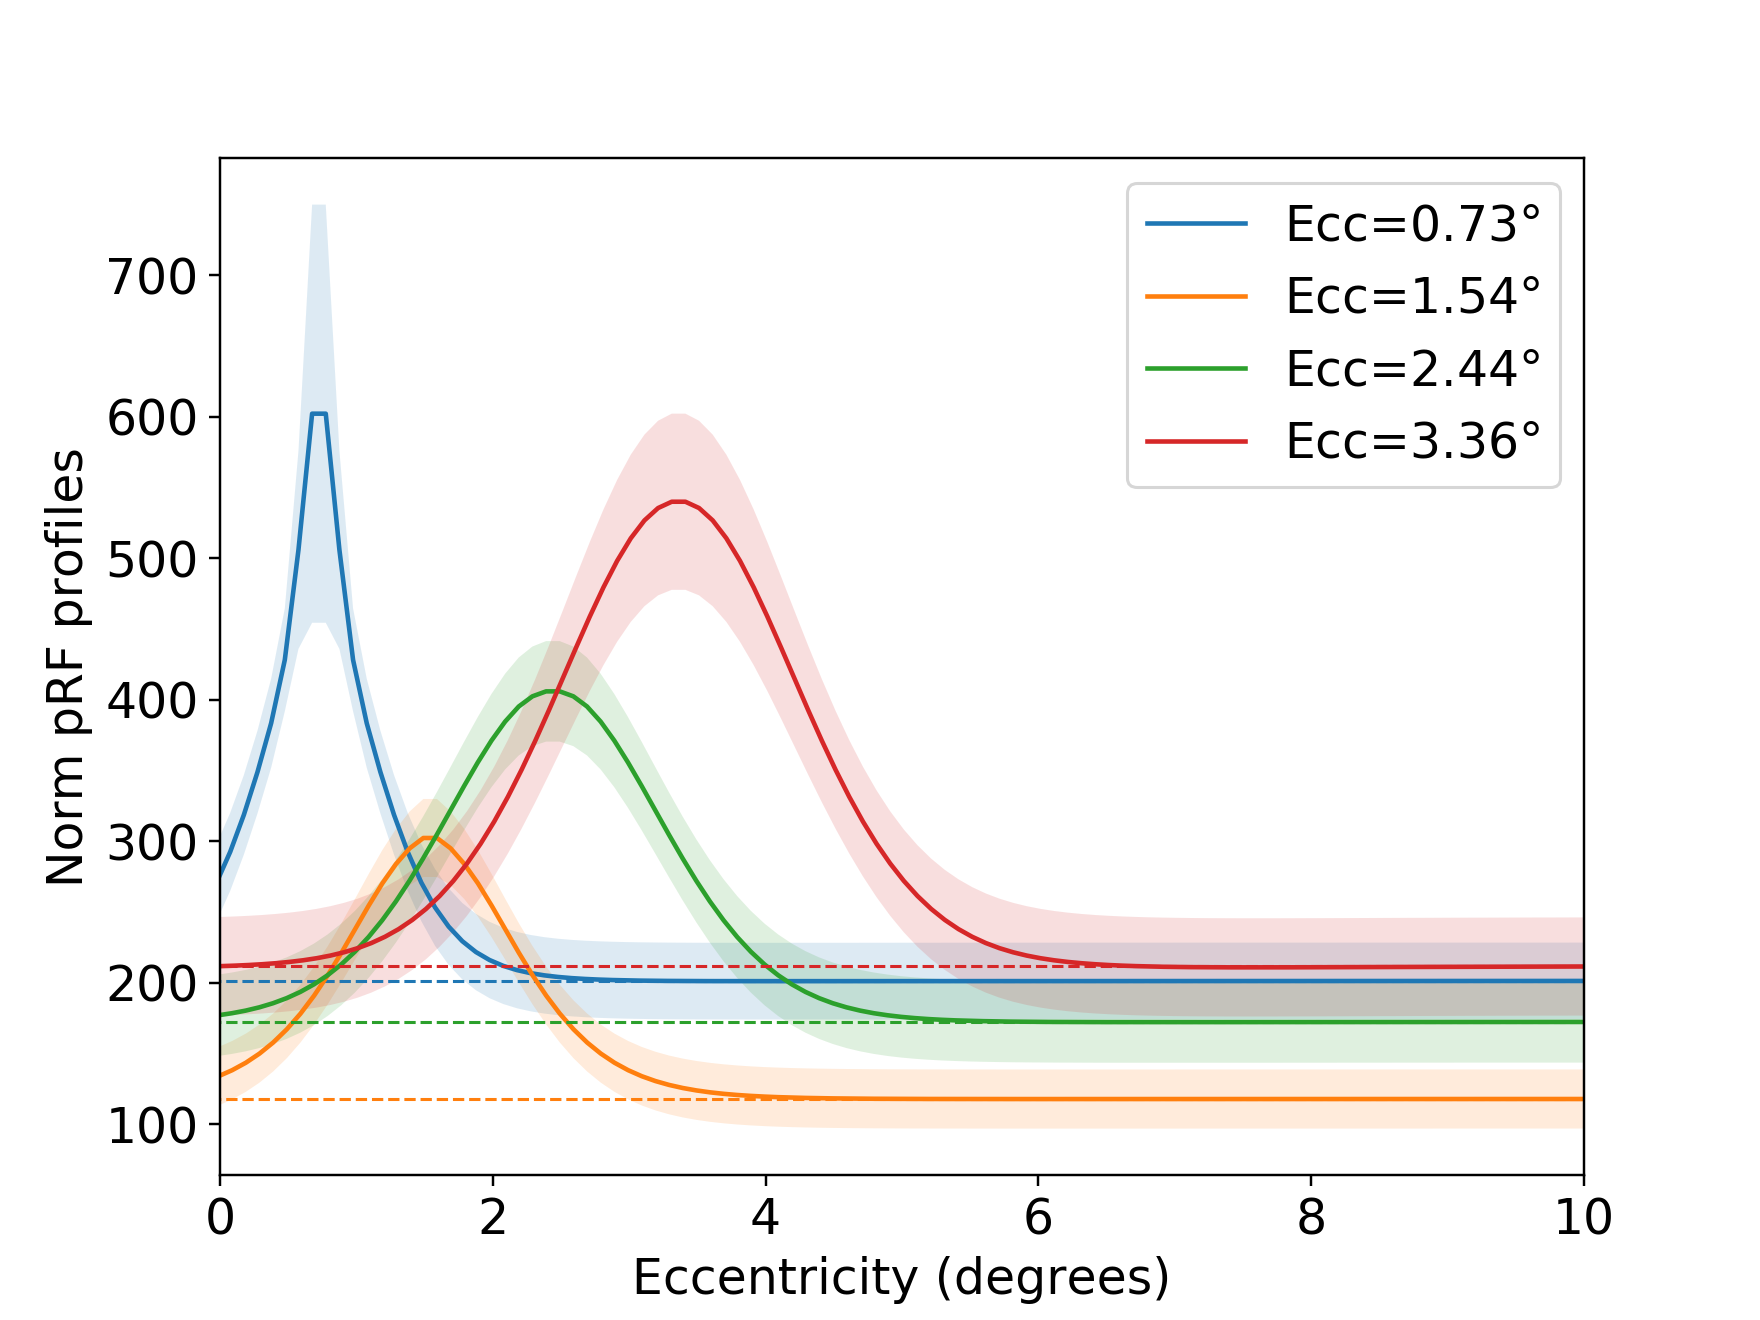

<IPython.core.display.Javascript object>


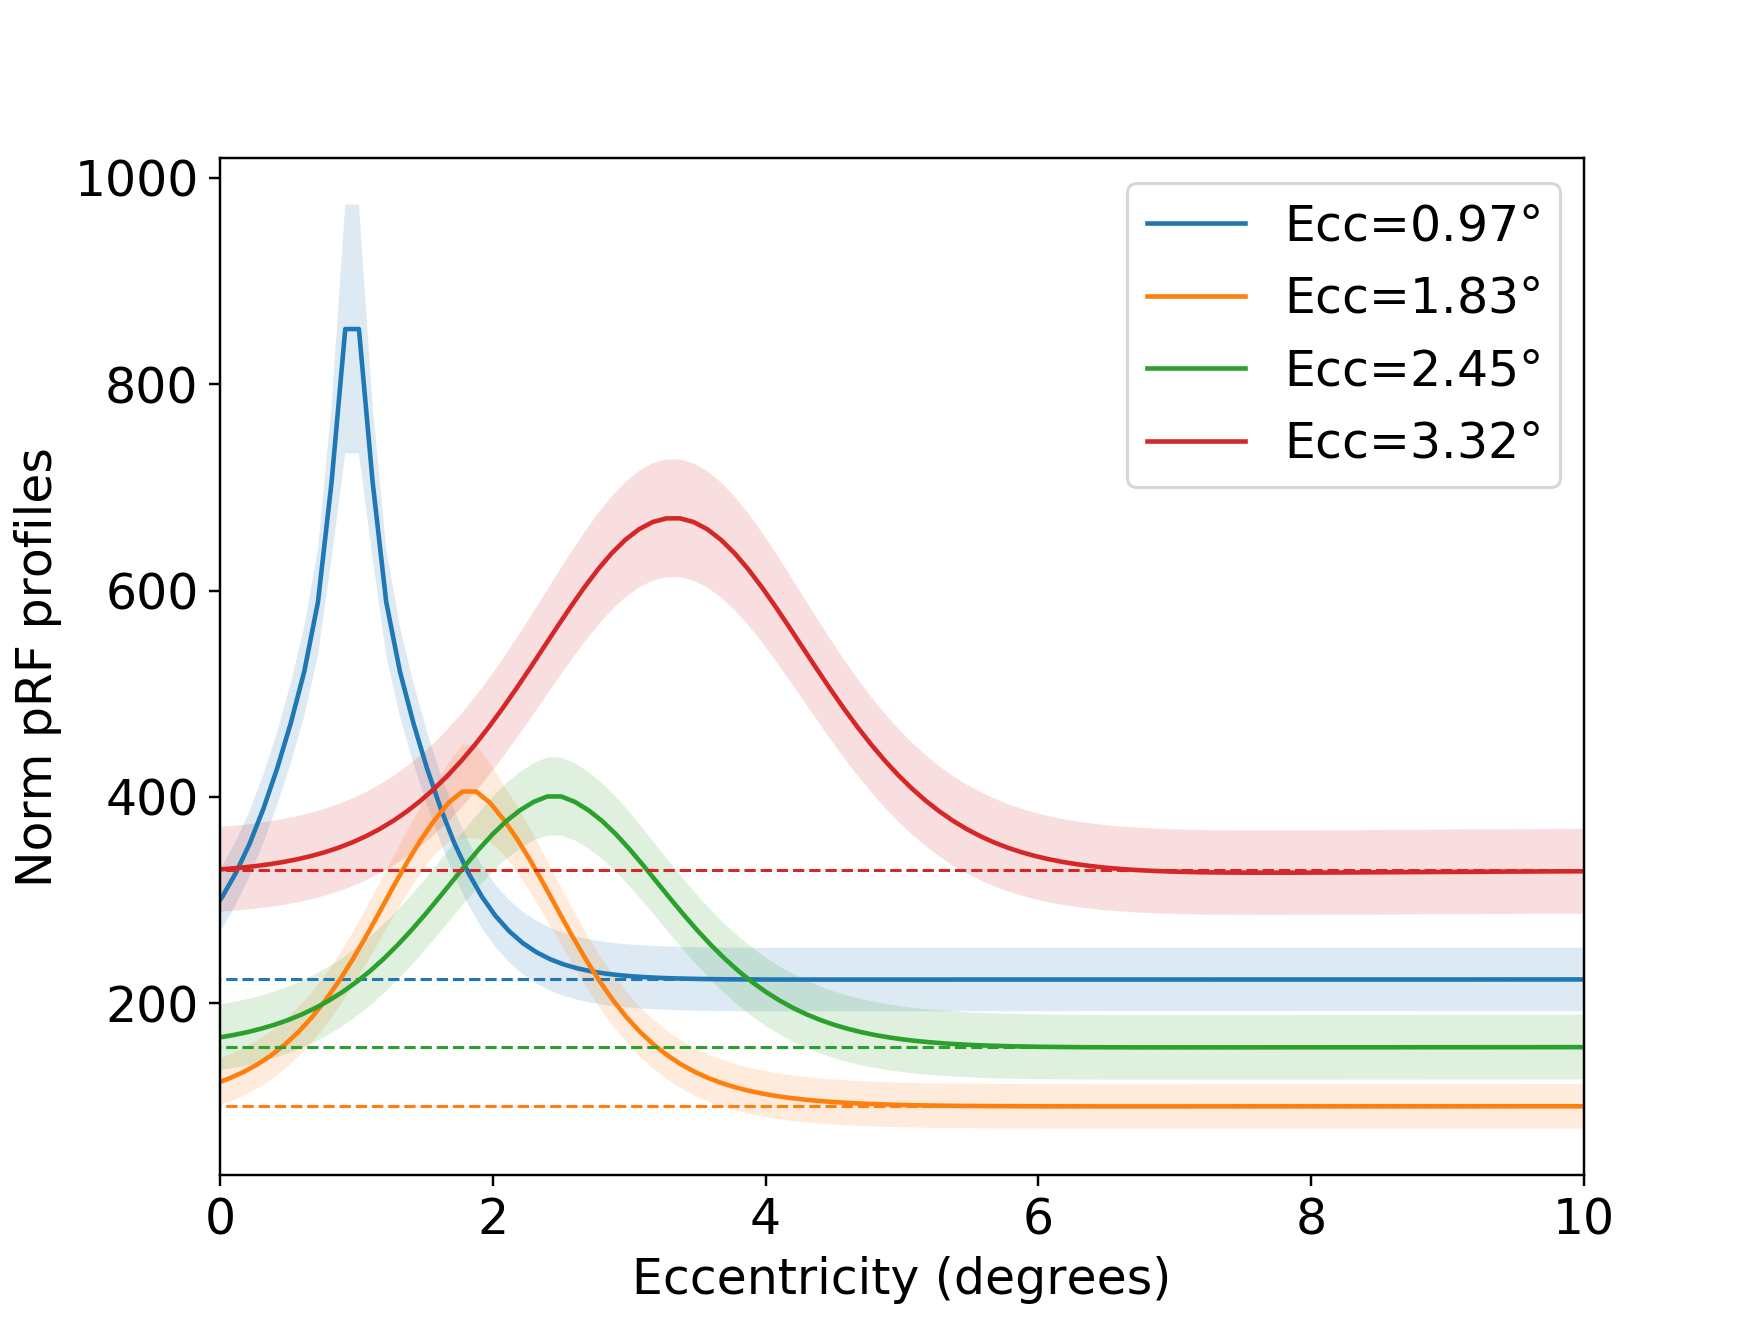

<IPython.core.display.Javascript object>


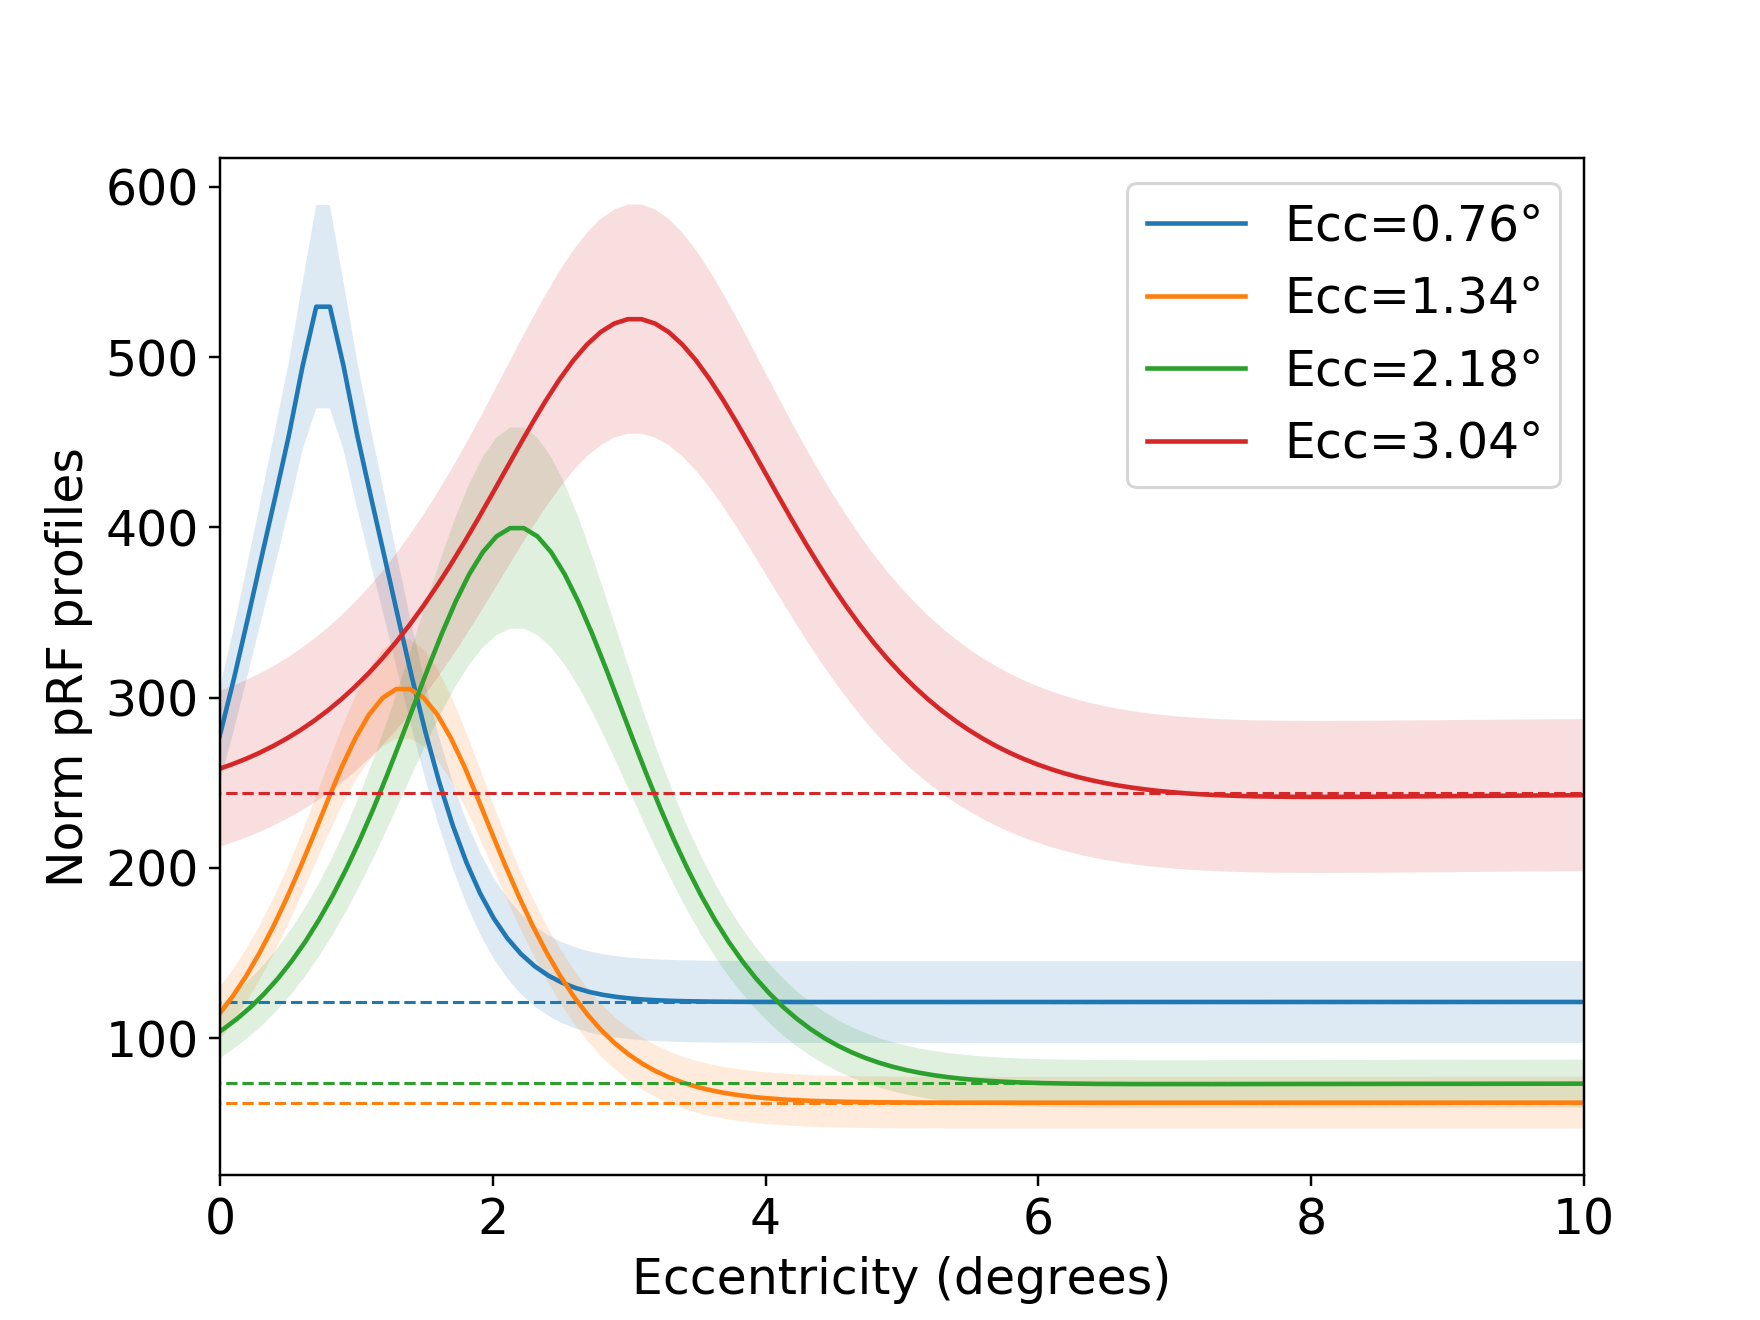

In [361]:
# binned eccentricity vs other parameters relationships
rsq_thresh = 0.3

ecc_stats = {}
profile_stats = {}


for roi in ['custom.V1', 'custom.V2', 'custom.V3']:#, 'V3A', 'V3B', 'hV4', 'LO1', 'TO1']:#idx_rois:
    
    ecc_stats[roi] = {}
    profile_stats[roi] = {}
    
    alpha_roi = (roi_mask(idx_rois[roi],alpha_norm)>rsq_thresh) 
    if alpha_roi.sum()>40:    
        pl.figure(roi, figsize=(8, 6))
        #pl.title(subj+' '+roi+' Norm profiles')
        ecc_sorted = np.argsort(ecc[alpha_roi], axis=0)
        #mask_ecc_sorted=[]
        #for elem in ecc_sorted[:,3]:
        #    mask_ecc_sorted.append(np.sum(nonzerovar_mask[:elem]))
        #mask_ecc_sorted=np.array(mask_ecc_sorted)    
        split_ecc_bins = np.array_split(ecc_sorted, 4, axis=0)

        ecc_stats[roi] = []
        profile_stats[roi] = []

        for ecc_quantile in split_ecc_bins:

            #hacky as per usual: 3 is the norm model index in ecc and rsq dataset
            ecc_stats[roi].append(weightstats.DescrStatsW(ecc[alpha_roi,3][ecc_quantile[:,3]],
                                                                      weights=rsq[alpha_roi,3][ecc_quantile[:,3]]))
            
            # different ways of calculating the profile VS eccentricity relationship
            #### weighted mean of parameters in each ecc bin
            #norm_bin_mean = weightstats.DescrStatsW(norm_params_full[alpha_roi,:][ecc_quantile[:,3]],
            #                                        weights=rsq[alpha_roi,3][ecc_quantile[:,3]]).mean   
            #bin_profile = fwhmax_fwatmin('Norm', norm_bin_mean, normalize_RFs, return_profiles=True)[1]
            #plot = pl.plot(np.linspace(-50,50,1000)+ecc_stats[roi][-1].mean, bin_profile,
            #              label=f'Ecc={ecc_stats[roi][-1].mean:.2f}')
            


            #### weighted mean of profiles in each eccentricity bin           
            profile_stats[roi].append(weightstats.DescrStatsW(norm_profiles[:,alpha_roi][:,ecc_quantile[:,3]].T,
                                                    weights=rsq[alpha_roi,3][ecc_quantile[:,3]]))
            
            plot = pl.plot(np.linspace(-50,50,1000)+ecc_stats[roi][-1].mean, profile_stats[roi][-1].mean,
                          label=f'Ecc={ecc_stats[roi][-1].mean:.2f}$\degree$')
            
            pl.fill_between(np.linspace(-50,50,1000)+ecc_stats[roi][-1].mean, profile_stats[roi][-1].zconfint_mean(alpha=0.05)[0],
                           profile_stats[roi][-1].zconfint_mean(alpha=0.05)[1], facecolor=plot[0].get_color(),
                           alpha=0.15)
            
            pl.plot(np.linspace(-50,50,1000), np.ones(1000)*plot[0].get_ydata()[-1], color=plot[0].get_color(),
                   linestyle='--', linewidth=1)

        pl.legend(loc=0)
        pl.xlim((0,10))
        pl.xlabel('Eccentricity (degrees)')
        pl.ylabel('Norm pRF profiles')
            
        #pl.savefig('/Users/marcoaqil/PRFMapping/Figures/'+subj+'_'+
        #           roi+'_Norm-profiles.png', dpi=200, bbox_inches='tight')
            
    else:
        print(roi+" has no vertices/voxels above specified rsq threshold")
    
    
    

In [362]:
pl.close('all')

In [ ]:
for roi in ['custom.V1', 'custom.V2', 'custom.V3']:
    alpha_roi = roi_mask(idx_rois[roi],alpha_norm)>rsq_thresh
    
    pl.figure()
    pl.title(roi+" Baselines scatter")
    pl.ylabel("Neural baseline (C)")
    pl.xlabel("Surround baseline (D)")
    pl.scatter(baselines[alpha_roi,1], baselines[alpha_roi,0], s=1)

In [ ]:
#plotting baseline average values per roi

pl.figure()
pl.title("Norm model baselines")
pl.ylabel("Mean value (rsq weighted)")

bar_positions = np.array([0,0.1,0.2])
x_ticks = []
x_labels = []

for roi in ['custom.V1', 'custom.V2', 'custom.V3']:
    alpha_roi = roi_mask(idx_rois[roi],alpha_norm)>rsq_thresh
    if alpha_roi.sum()>40:
        
        height_1 = weightstats.DescrStatsW(baselines[alpha_roi,0],
                                                    weights=rsq[alpha_roi,3])
        height_2 = weightstats.DescrStatsW(baselines[alpha_roi,1],
                                                    weights=rsq[alpha_roi,3])
        height_3 = weightstats.DescrStatsW(baselines[alpha_roi,2],
                                                    weights=rsq[alpha_roi,3])
        
        p1=pl.bar(bar_positions, height=[height_1.mean, height_2.mean, height_3.mean], width=0.1,
                  yerr=np.array([np.abs(height_1.zconfint_mean(alpha=0.05)-height_1.mean),
                                np.abs(height_2.zconfint_mean(alpha=0.05)-height_2.mean),
                                np.abs(height_3.zconfint_mean(alpha=0.05)-height_3.mean)]).T, color=
                  ['blue','orange', 'red'], edgecolor='black')
        x_ticks.append(bar_positions.mean())
        x_labels.append(roi)
        bar_positions+=0.4
    else:
        print(roi+" has no vertices/voxels above specified rsq threshold")
            
pl.xticks(x_ticks, x_labels)


pl.legend((p1[0],p1[1], p1[2]),('Neural Baseline','Surround Baseline', 'Ratio'),loc=0)


<IPython.core.display.Javascript object>


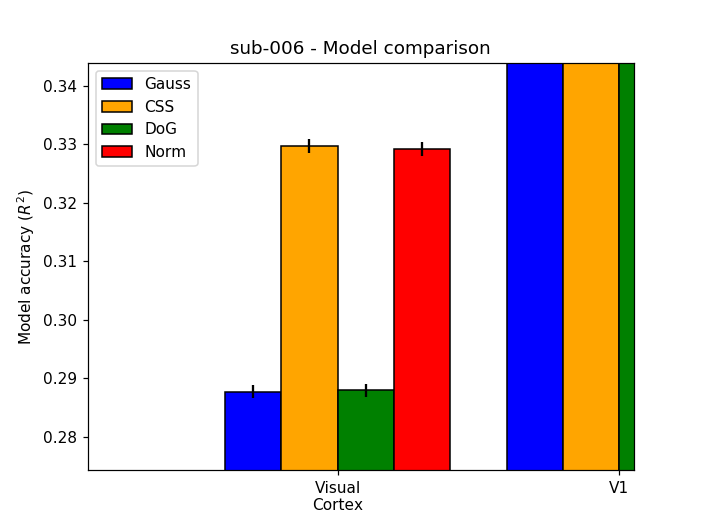

In [128]:
#plotting rsq per roi
rsq_thresh=0.0
pl.figure()
pl.title(subj+' - Model comparison')
pl.ylabel("Model accuracy ($R^{2}$)")

bar_positions = np.array([0,0.1,0.2,0.3])
x_ticks = []
x_labels = []

for roi in ['visual_system', 'custom.V1', 'custom.V2', 'custom.V3', 'V3A', 'V3B', 'hV4', 'VO1', 'VO2', 'LO1', 'LO2', 'TO1', 'TO2',]:
    alpha_roi = roi_mask(idx_rois[subj][roi], subj_res['Processed results']['Alpha']['all'])>rsq_thresh 
    if alpha_roi.sum()>1:        
        p1=pl.bar(bar_positions, height=np.median(rsq[alpha_roi],axis=0), width=0.1,
                  yerr=sem(rsq[alpha_roi],axis=0), color=
                  ['blue','orange','green','red'],edgecolor='black')
        x_ticks.append(bar_positions.mean())
        roi_name = roi if 'custom' not in roi else roi.replace('custom.','')
        roi_name = 'Visual\nCortex' if roi == 'visual_system' else roi_name
        x_labels.append(roi_name)
        bar_positions+=0.5
    else:
        print(roi+" has no vertices/voxels above specified rsq threshold")
            
pl.xticks(x_ticks, x_labels)

pl.ylim(bottom=0.2)
pl.legend((p1[0],p1[1],p1[2],p1[3]),('Gauss','CSS','DoG','Norm'),loc=0)


In [123]:

for roi in idx_rois:
    print(roi)
    try:
        print(ks_2samp(rsq[roi_mask(idx_rois[subj][roi],alpha)>rsq_thresh,1],rsq[roi_mask(idx_rois[roi],alpha)>rsq_thresh,3]))
    except:
        print(roi+" has no vertices/voxels above specified rsq threshold")


sub-006
sub-006 has no vertices/voxels above specified rsq threshold


In [49]:
#making t1w nifti images (use nilearn image) (flask to make javascript?)
import nibabel as nib
maskk = np.load('/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/T1w_results/sub-006_mask_space-T1w.npy')
resxx = np.load('/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/T1w_results/sub-006_iterparams-norm_space-T1w2019-12-12-15-24-19.npy')
aha = np.zeros(maskk.shape)
aha[maskk] = resxx[:,-1]

ref_img = nib.load('/Users/marcoaqil/Downloads/sub-006_ses-1_task-1R_run-1_space-T1w_desc-brain_mask.nii.gz')
affine, header = ref_img.affine, ref_img.header

nib.Nifti1Image(aha, affine, header).to_filename('/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/T1w_results/sub-006_rsq_space-T1w')

xfm_trans = cortex.xfm.Transform(np.identity(4), 
                                    '/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/T1w_results/sub-006_rsq_space-T1w.nii')
xfm_trans.save('sub-006', 'func_space-t1w')


vol_data = cortex.Volume2D('/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/T1w_results/sub-006_rsq_space-T1w.nii', 
                         '/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/T1w_results/sub-006_rsq_space-T1w.nii',
                         'sub-006',
                         'func_space-t1w',
                           vmin=0.2,
                           vmax=0.6,
                           vmin2=0.05,
                           vmax2=0.2,
                          cmap='Jet_2D_alpha')


cortex.webgl.show(vol_data,                  
                 with_curvature=True, 
                 with_labels=True, 
                 with_rois=True, 
                 with_borders=True, 
                 with_colorbar=True)


Started server on port 57730


<JS: window.viewer>

Stopping server


In [ ]:
#the following cells are in case we want to quickly look at some specific model/data timecourse

In [37]:
analysis_settings = '/Users/marcoaqil/analysis_settings_cartesius.yml'

local_files = '/Users/marcoaqil/prfpy_norm/analysis_settings.yml'

with open(analysis_settings) as f:
    analysis_info = yaml.safe_load(f)

with open(local_files) as f:
    analysis_info_local = yaml.safe_load(f)

    
screenshot_paths = analysis_info_local["screenshot_paths"]

# note that screenshot paths and task names should be in the same order
n_pix = analysis_info["n_pix"]
discard_volumes = 8#analysis_info["discard_volumes"]
#screenshot_paths = analysis_info["screenshot_paths"]
screen_size_cm = analysis_info["screen_size_cm"]
screen_distance_cm = analysis_info["screen_distance_cm"]
TR = analysis_info["TR"]

task_names = analysis_info["task_names"]
#data_path = analysis_info["data_path"]
data_path=analysis_info_local["data_path"]
fitting_space = analysis_info["fitting_space"]

window_length = analysis_info["window_length"]
polyorder = analysis_info["polyorder"]
highpass = analysis_info["highpass"]
add_mean = analysis_info["add_mean"]

n_jobs = analysis_info["n_jobs"]
hrf = analysis_info["hrf"]
verbose = analysis_info["verbose"]
rsq_threshold = analysis_info["rsq_threshold"]
models_to_fit = analysis_info["models_to_fit"]
n_batches = analysis_info["n_batches"]
fit_hrf = analysis_info["fit_hrf"]

crossvalidate = analysis_info["crossvalidate"]
if crossvalidate and "fit_task" in analysis_info and "fit_runs" in analysis_info:
    print("Can only specify one between fit_task and fit_runs for crossvalidation.")
    raise IOError
elif crossvalidate and "fit_task" in analysis_info:
    print("Performing crossvalidation over tasks.") 
    fit_task = analysis_info["fit_task"]
    fit_runs = None
elif crossvalidate and "fit_runs" in analysis_info:
    print("Performing crossvalidation over runs.")    
    fit_task = None
    fit_runs = analysis_info["fit_runs"]
else:
    print("Not performing crossvalidation.")
    fit_task = None
    fit_runs = None        
    
xtol = analysis_info["xtol"]
ftol = analysis_info["ftol"]

dm_edges_clipping = analysis_info["dm_edges_clipping"]
baseline_volumes_begin_end = analysis_info["baseline_volumes_begin_end"]
min_percent_var = analysis_info["min_percent_var"]

param_bounds = analysis_info["param_bounds"]
pos_prfs_only = analysis_info["pos_prfs_only"]
normalize_RFs = analysis_info["normalize_RFs"]

surround_sigma_larger_than_centre = analysis_info["surround_sigma_larger_than_centre"]
positive_centre_only = analysis_info["positive_centre_only"]

param_constraints = surround_sigma_larger_than_centre or surround_sigma_larger_than_centre

n_chunks = analysis_info["n_chunks"]
refit_mode = analysis_info["refit_mode"].lower()

if "norm" in models_to_fit and "norm_model_variant" in analysis_info:
    norm_model_variant = analysis_info["norm_model_variant"]
else:
    norm_model_variant = "abcd"

if "roi_idx_path" in analysis_info and os.path.exists(analysis_info["roi_idx_path"]):
    roi_idx = np.load(analysis_info["roi_idx_path"])
    print("Using ROI mask from: "+analysis_info["roi_idx_path"])
else:
    roi_idx = None

if "data_scaling" in analysis_info:
    data_scaling = analysis_info["data_scaling"]
else:
    data_scaling = None

if not param_bounds and norm_model_variant != "abcd":
    print("Norm model variant "+norm_model_variant+" was selected, \
          but param_bounds=False. param_bounds will be set to True.")
    param_bounds = True



Performing crossvalidation over runs.


In [64]:
#create stim
prf_stim = create_full_stim(screenshot_paths,
                n_pix,
                discard_volumes,
                baseline_volumes_begin_end,                                         
                dm_edges_clipping,
                screen_size_cm,
                screen_distance_cm,
                TR,
                task_names)

Design matrix completed
Design matrix completed
Design matrix completed
Design matrix completed
Design matrix completed


In [193]:
from utils.utils import prepare_data
tc_full_iso_nonzerovar_dict = prepare_data('sub-001',
                                                   prf_stim,
                                                   prf_stim,
                                                   
                                                   discard_volumes,
                                                   min_percent_var,
                                                   
                                                   window_length,
                                                   polyorder,
                                                   highpass,
                                                   add_mean,
                                                   
                                                   data_path,
                                                   fitting_space,
                                                   data_scaling,
                                                   roi_idx,
                                                   
                                                   crossvalidate,
                                                   fit_runs,
                                                   fit_task)

For task 1R, hemisphere L of subject sub-001, a total of 2 runs were found.
For task 1S, hemisphere L of subject sub-001, a total of 2 runs were found.
For task 2R, hemisphere L of subject sub-001, a total of 2 runs were found.
For task 4F, hemisphere L of subject sub-001, a total of 2 runs were found.
For task 4R, hemisphere L of subject sub-001, a total of 2 runs were found.
For task 1R, hemisphere L of subject sub-001, a total of 2 runs were found.
For task 1S, hemisphere L of subject sub-001, a total of 2 runs were found.
For task 2R, hemisphere L of subject sub-001, a total of 2 runs were found.
For task 4F, hemisphere L of subject sub-001, a total of 2 runs were found.
For task 4R, hemisphere L of subject sub-001, a total of 2 runs were found.
For task 1R, hemisphere R of subject sub-001, a total of 2 runs were found.
For task 1S, hemisphere R of subject sub-001, a total of 2 runs were found.
For task 2R, hemisphere R of subject sub-001, a total of 2 runs were found.
For task 4F,

In [203]:
#initialize models 
gg = Iso2DGaussianGridder(stimulus=prf_stim,
                          hrf=hrf,
                          filter_predictions=True,
                          window_length=window_length,
                          polyorder=polyorder,
                          highpass=highpass,
                          add_mean=add_mean,
                          normalize_RFs=normalize_RFs)

gg_css = CSS_Iso2DGaussianGridder(stimulus=prf_stim,
                          hrf=hrf,
                          filter_predictions=True,
                          window_length=window_length,
                          polyorder=polyorder,
                          highpass=highpass,
                          add_mean=add_mean,
                          normalize_RFs=normalize_RFs)

gg_norm = Norm_Iso2DGaussianGridder(stimulus=prf_stim,
                                    hrf=hrf,
                                    filter_predictions=True,
                                    window_length=window_length,
                                  polyorder=polyorder,
                                  highpass=highpass,
                                  add_mean=add_mean,
                                    normalize_RFs=normalize_RFs)

gg_dog = DoG_Iso2DGaussianGridder(stimulus=prf_stim,
                                  hrf=hrf,
                                  filter_predictions=True,
                                  window_length=window_length,
                                  polyorder=polyorder,
                                  highpass=highpass,
                                  add_mean=add_mean,
                                  normalize_RFs=normalize_RFs)

In [204]:
tc_full_iso_nonzerovar_dict['tc'] = np.array_split(tc_full_iso_nonzerovar_dict['tc'], n_chunks)[0]
if crossvalidate:
    tc_full_iso_nonzerovar_dict['tc_test'] = np.array_split(tc_full_iso_nonzerovar_dict['tc_test'], n_chunks)[0]

gf = Iso2DGaussianFitter(
    data=tc_full_iso_nonzerovar_dict['tc'], gridder=gg, n_jobs=8)
gf.fit_hrf = fit_hrf
# gauss grid params
grid_nr = 20
max_ecc_size = prf_stim.screen_size_degrees/2.0
sizes, eccs, polars = max_ecc_size * np.linspace(0.25, 1, grid_nr)**2, \
    max_ecc_size * np.linspace(0.1, 1, grid_nr)**2, \
    np.linspace(0, 2*np.pi, grid_nr)
gf.grid_fit(ecc_grid=eccs,
                polar_grid=polars,
                size_grid=sizes,
                verbose=True,
                n_batches=8,
                pos_prfs_only=pos_prfs_only)

Each batch contains approx. 1 voxels.


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished


In [167]:
ranpar=np.random.rand(15,7)
fake_data = gg_css.return_prediction(*list(ranpar[:,:-1].T))
gf_css = CSS_Iso2DGaussianFitter(data=fake_data,
                                       gridder=gg_css,
                                       n_jobs=1)

In [180]:
gf_css.iterative_search_params=ranpar
gf_css.rsq_mask = (np.ones(15)).astype(bool)
gf_css.crossvalidate_fit(fake_data+3*np.random.rand(fake_data.shape[0],fake_data.shape[1]))

In [181]:
gf_css.iterative_search_params

array([[ 0.65086035,  0.30372529,  0.42315795,  0.44303777,  0.66643762,
         0.87644019,  0.13312038],
       [ 0.26643503,  0.36801376,  0.59089041,  0.70429362,  0.26667952,
         0.61106889,  0.34463743],
       [ 0.52271062,  0.57200384,  0.14114279,  0.80495547,  0.15518434,
         0.48346153, -2.64638405],
       [ 0.89777407,  0.2146104 ,  0.94008348,  0.6640464 ,  0.21355406,
         0.30551216, -0.85116442],
       [ 0.30776865,  0.10702313,  0.68906541,  0.32592576,  0.3383528 ,
         0.68091639, -0.10391479],
       [ 0.64443002,  0.42252717,  0.90326124,  0.06981913,  0.76481668,
         0.37817212, -2.95143587],
       [ 0.43181048,  0.44349879,  0.13476344,  0.54490993,  0.00672558,
         0.49884401, -2.729079  ],
       [ 0.63323897,  0.39533372,  0.82319413,  0.64318414,  0.88160718,
         0.98460512,  0.97595684],
       [ 0.11252966,  0.06516818,  0.16238468,  0.76991915,  0.06535806,
         0.0952788 , -2.47374888],
       [ 0.19673057,  0.0098

In [65]:
bar_passes = prf_stim.design_matrix.sum((0,1))

<IPython.core.display.Javascript object>


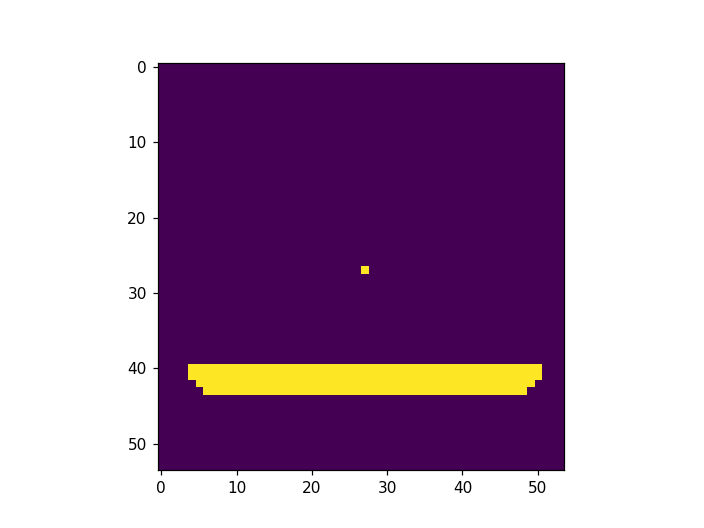

In [71]:
fig=pl.figure()
pl.imshow(prf_stim.design_matrix[:,:,344])

<IPython.core.display.Javascript object>


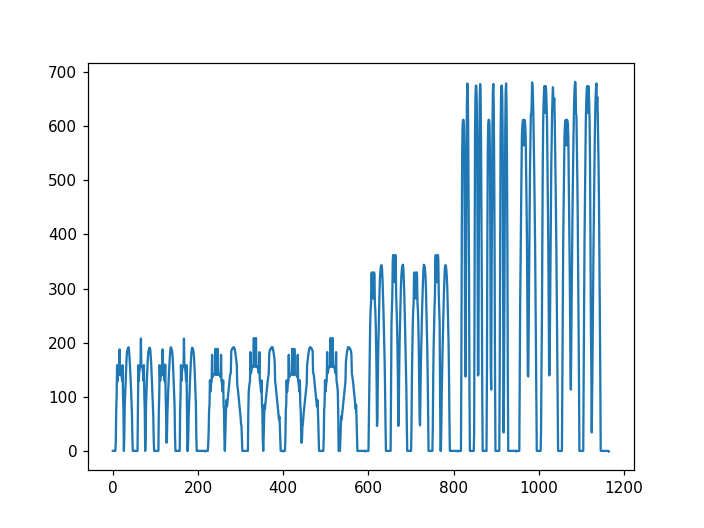

In [67]:
fig=pl.figure()
pl.plot(bar_passes)

<IPython.core.display.Javascript object>


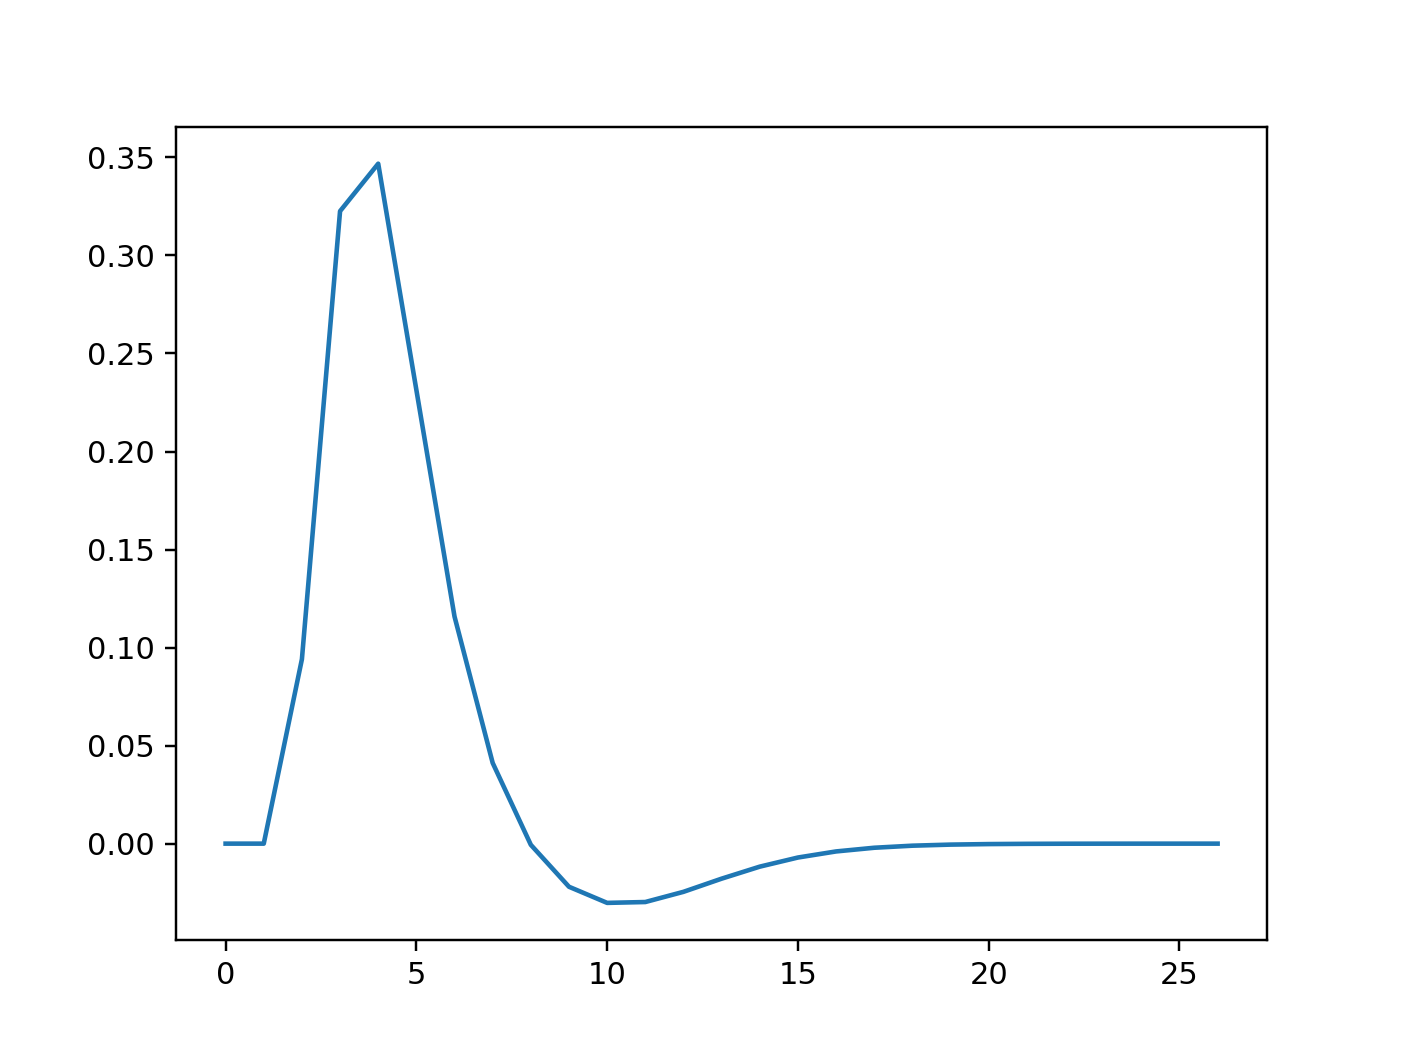

In [76]:
pl.figure()
pl.plot(gg_norm.hrf)

In [118]:
gg_norm.polyorder=1
norm_tc=gg_norm.return_prediction(*list(np.random.rand(10,5)))
norm_tc.shape

(5, 1180)

In [111]:
norm_tc_ndi=gg_norm.return_prediction(*list(np.array([0,0,2,10,10,1,5,1,2]).T))

In [116]:
gg_norm.polyorder=1
norm_tc_fft=gg_norm.return_prediction(*list(np.array([0,0,2,10,10,1,5,1,2]).T))

<IPython.core.display.Javascript object>


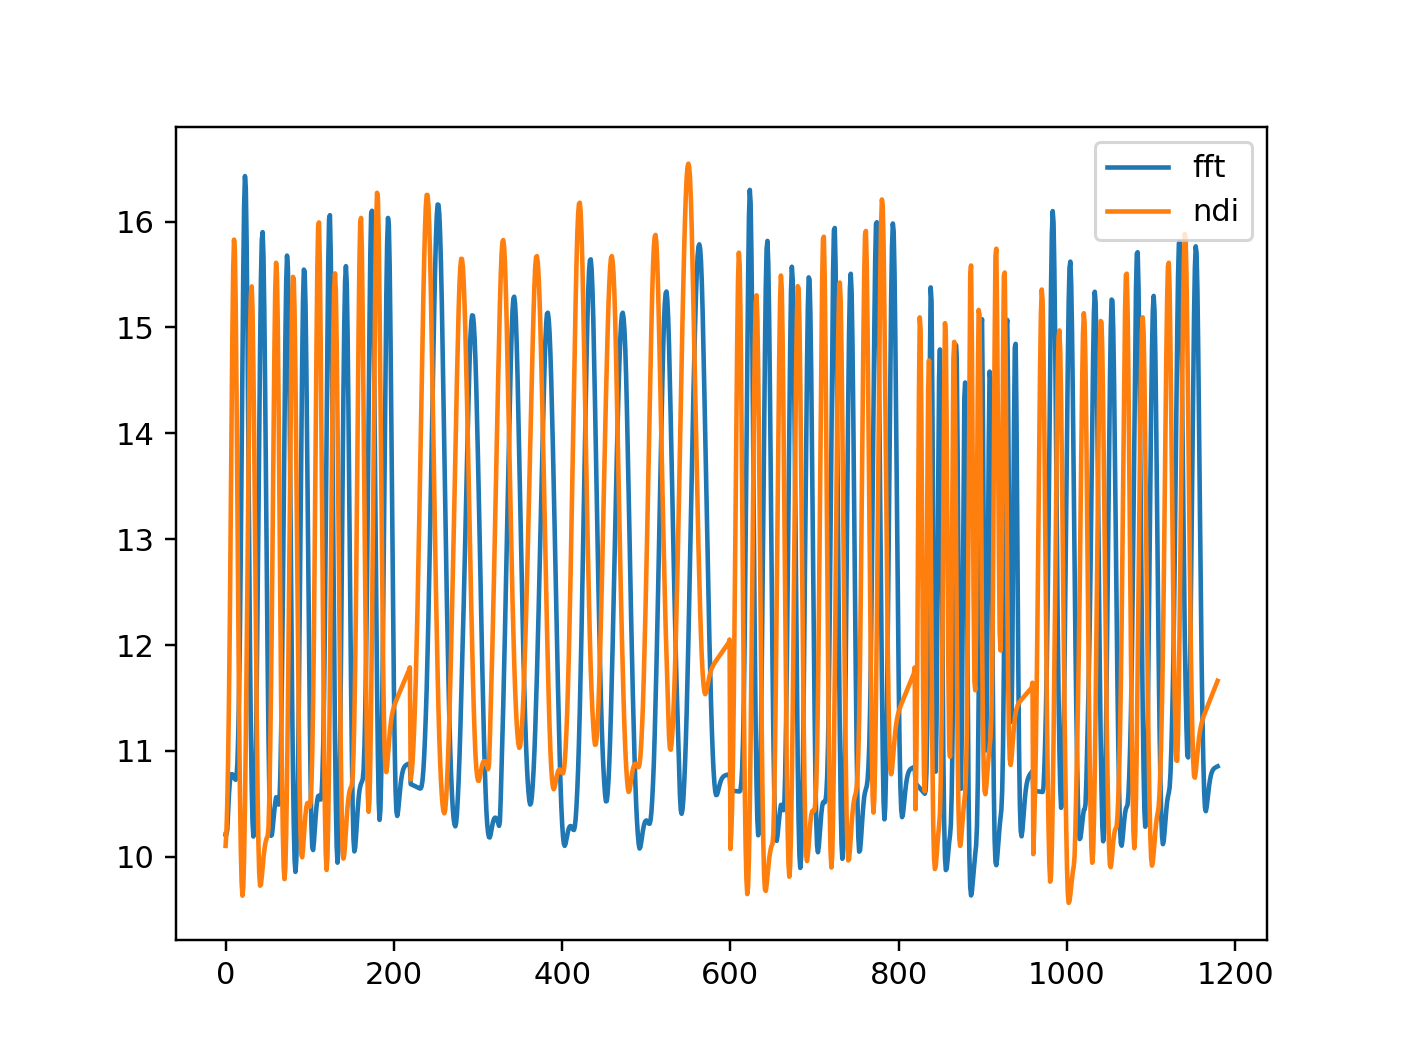

In [117]:
pl.figure()
pl.plot(norm_tc_fft[0],label='fft')
pl.plot(norm_tc_ndi[0],label='ndi')
pl.legend()

<IPython.core.display.Javascript object>


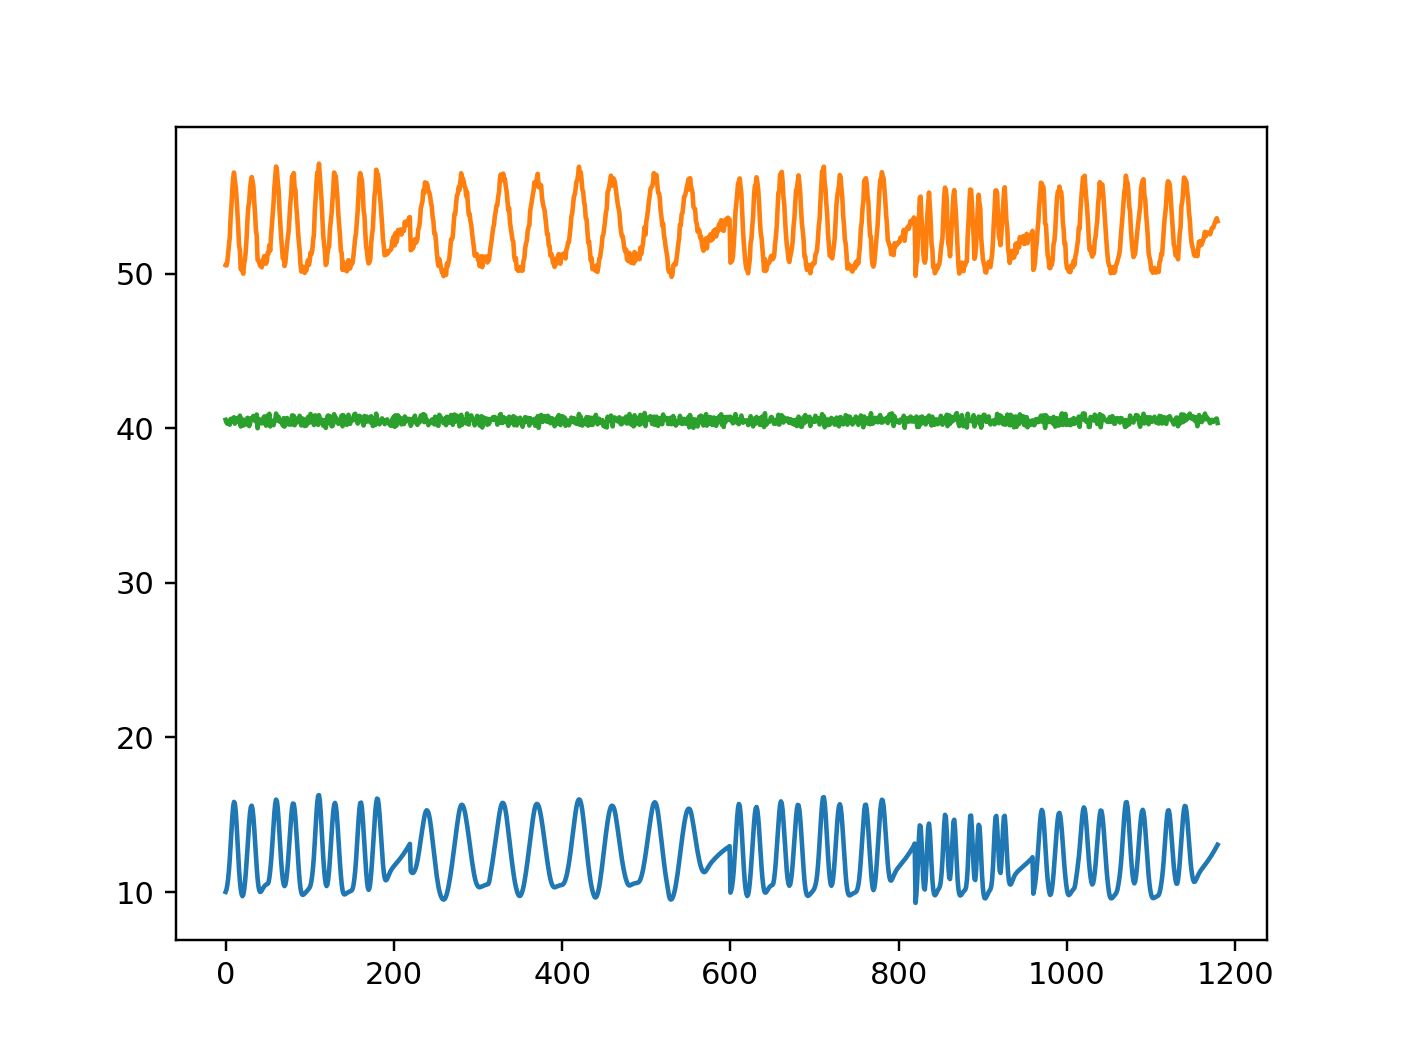

In [100]:
pl.figure()
pl.plot(norm_tc[0])
a=norm_tc[0]+30+np.random.rand(len(norm_tc[0]))
b=norm_tc[0]+50+np.random.rand(len(norm_tc[0]))
c=norm_tc[0]+150+np.random.rand(len(norm_tc[0]))
#pl.plot(a)
#pl.plot(b)
#pl.plot(c)
pl.plot(np.median([norm_tc[0],a,b,c],axis=0))
pl.plot(np.median([norm_tc[0],a,b,c],axis=0)-norm_tc[0])

In [32]:
pl.plot(np.median([norm_tc[0]+50,norm_tc[0]+30,norm_tc[0],norm_tc[0]+150], axis=0) - norm_tc[0])

In [124]:
timecourse = np.load('/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/smaller_bounds/sub-006_timecourse_space-fsnative.npy')


In [13]:
from copy import deepcopy
test_stim = PRFStimulus2D(10,10,np.random.rand(10,10,10),1.5)

haha = deepcopy(prf_stim)

prf_stim = test_stim

haha.design_matrix.shape

(54, 54, 1165)

In [13]:

tc_vox = timecourse[12,:]

<IPython.core.display.Javascript object>


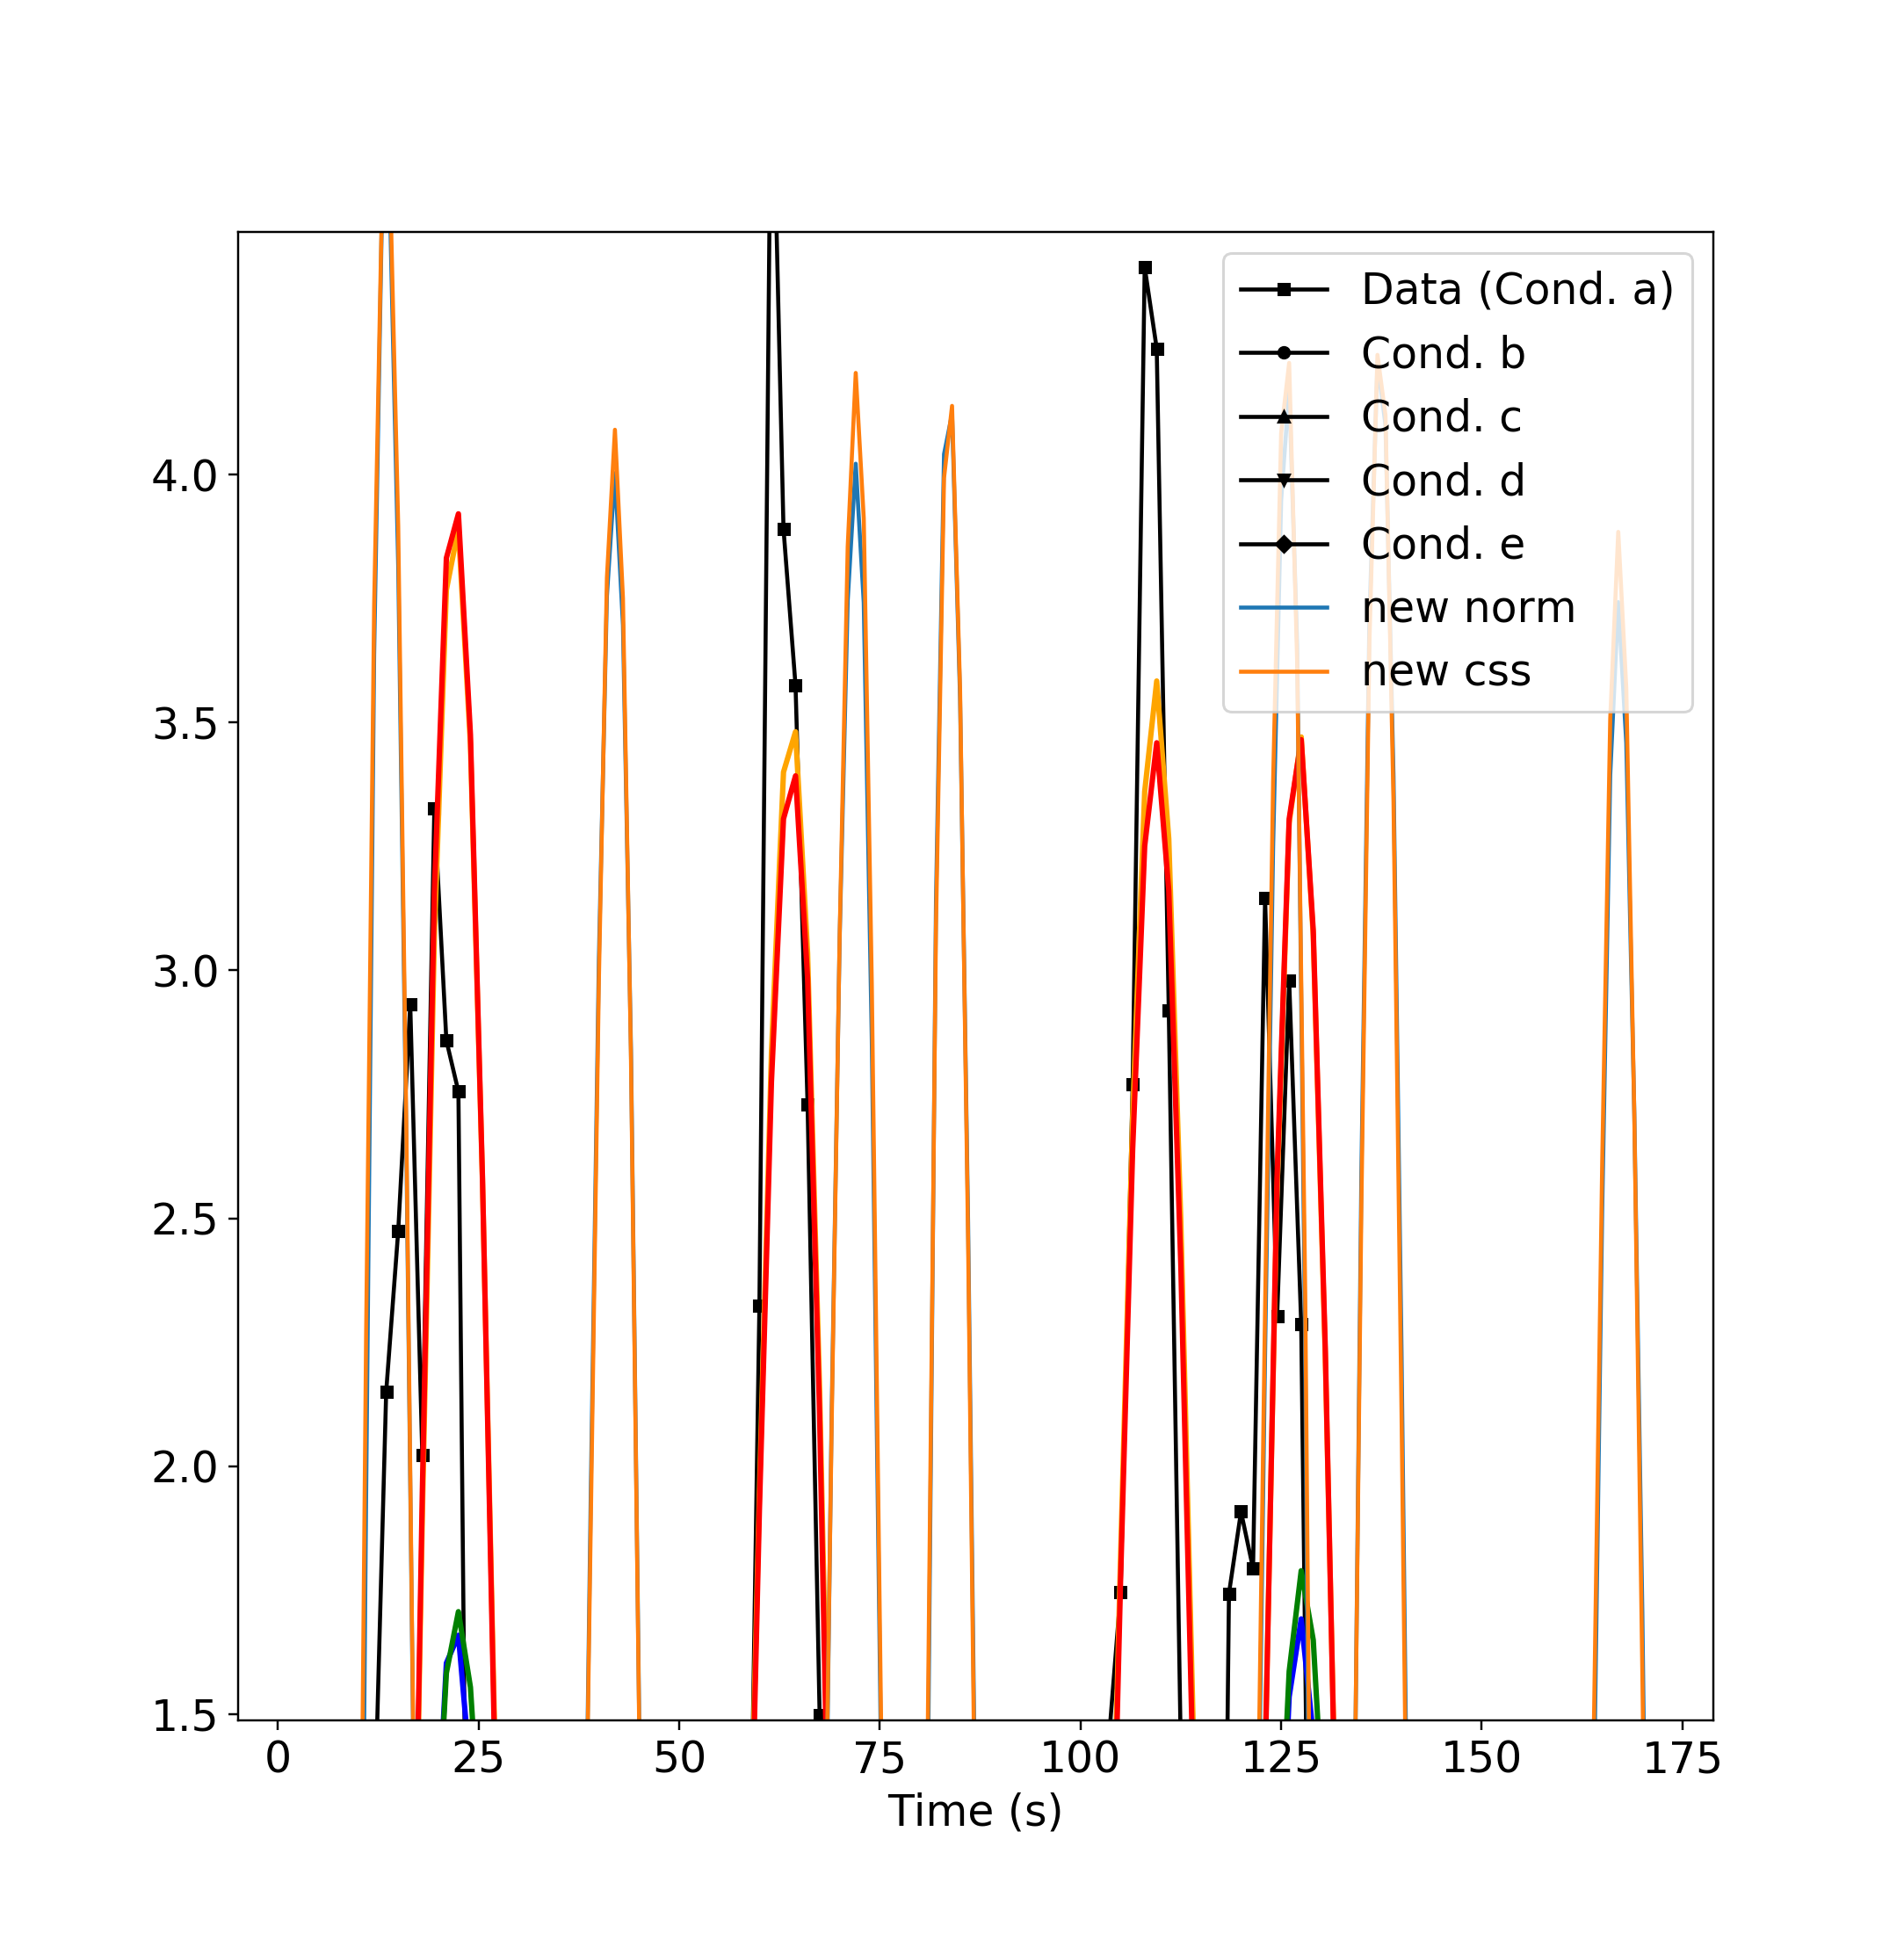

gauss rsq: 0.6134813958888129
css rsq: 0.7176304456778766
dog rsq: 0.625191838436771
norm rsq: 0.7089548160243349
new norm rsq: 0.775869165333088
new css rsq: 0.7862624480604232
gauss params
[ 1.57078683 -3.23347826  1.51733844  0.04441227 98.87609332  0.61348142]
css params
[ 1.57171012 -3.18526582  0.86276301  1.91285737 98.39508613  0.27102722
  0.71763047]
dog params
[ 1.54168695 -3.05274117  1.86423697  0.04064026 99.07661842  0.0030841
 42.76546101  0.62519186]
norm params
[  1.6126288   -3.27140605   1.31095913  30.25247063  97.36434061
   3.37459472   1.43215644 101.72093309  92.30388769   0.70895484]


In [402]:
%matplotlib notebook
rsq_thresh=0.7

roi = 'visual_system'
#alpha_roi = roi_mask(idx_rois[roi],alpha)>rsq_thresh

alpha_roi = alpha>rsq_thresh#roi_mask(idx_rois[roi],alpha)>rsq_thresh

#create timecourses
vox_num=np.argmin((rsq[:,3]-rsq[:,1])*alpha_roi)#50370



vox_num = np.sum(nonzerovar_mask[:vox_num])
tc_vox=timecourse[vox_num] - 100




#norm_grid_tc=gg_norm.return_prediction(*list(norm_grid[vox_num,:-1]))
norm_tc=gg_norm.return_prediction(*list(norm_res[vox_num,:-1]))  - 100
gauss_tc=gg.return_prediction(*list(gauss[vox_num,:-1])) - 100
css_tc=gg_css.return_prediction(*list(css_res[vox_num,:-1])) - 100
dog_tc=gg_dog.return_prediction(*list(dog_res[vox_num,:-1])) - 100
norm_updated=gg_norm.return_prediction(*list(gf_norm.iterative_search_params[0,:-1])) - 100
css_updated=gg_css.return_prediction(*list(gf_css.iterative_search_params[0,:-1])) - 100

times=np.arange(len(tc_vox))*1.5

fig=pl.figure(figsize=(4, 9))
pl.plot(times[:task_lengths[0]], tc_vox[:task_lengths[0]], label='Data (Cond. a)', marker='s', markersize=4, color='black', linestyle='-') 
pl.plot(times[task_lengths[0]:np.sum(task_lengths[:2])], tc_vox[task_lengths[0]:np.sum(task_lengths[:2])], label='Cond. b', marker='o', markersize=4, color='black', linestyle='-') 
pl.plot(times[np.sum(task_lengths[:2]):np.sum(task_lengths[:3])], tc_vox[np.sum(task_lengths[:2]):np.sum(task_lengths[:3])], label='Cond. c', marker='^', markersize=4, color='black', linestyle='-') 
pl.plot(times[np.sum(task_lengths[:3]):np.sum(task_lengths[:4])], tc_vox[np.sum(task_lengths[:3]):np.sum(task_lengths[:4])], label='Cond. d', marker='v', markersize=4, color='black', linestyle='-') 
pl.plot(times[np.sum(task_lengths[:4]):np.sum(task_lengths[:5])], tc_vox[np.sum(task_lengths[:4]):np.sum(task_lengths[:5])], label='Cond. e', marker='D', markersize=4, color='black', linestyle='-') 

pl.plot(times, gauss_tc, color='blue',linewidth=2)#,label='Gauss')
pl.plot(times, css_tc, color='orange',linewidth=2)#,label='CSS')
pl.plot(times, dog_tc, color='green',linewidth=2)#,label='DoG')
pl.plot(times, norm_tc, color='red',linewidth=2)#, label='Norm')


pl.plot(norm_updated,label='new norm')
pl.plot(css_updated,label='new css')
pl.legend(loc=1)


pl.xlabel('Time (s)')
#pl.ylabel('BOLD signal change (%)')

#pl.xlim(42,82)
#pl.xlim(350,390)
#pl.xlim(905,945)
#pl.xlim(1226.5,1266.5)
#pl.xlim(1663,1703)
#pl.ylim(-3,6)

np.set_printoptions(suppress=True)

print("gauss rsq: "+str(1-np.sum((tc_vox-gauss_tc)**2)/(timecourse.shape[-1]*np.var(tc_vox))))
print("css rsq: "+str(1-np.sum((tc_vox-css_tc)**2)/(timecourse.shape[-1]*np.var(tc_vox))))
print("dog rsq: "+str(1-np.sum((tc_vox-dog_tc)**2)/(timecourse.shape[-1]*np.var(tc_vox))))
print("norm rsq: "+str(1-np.sum((tc_vox-norm_tc)**2)/(timecourse.shape[-1]*np.var(tc_vox))))
print("new norm rsq: "+str(1-np.sum((tc_vox-norm_updated)**2)/(timecourse.shape[-1]*np.var(tc_vox))))

print("new css rsq: "+str(1-np.sum((tc_vox-css_updated)**2)/(timecourse.shape[-1]*np.var(tc_vox))))


print("gauss params")
print(gauss[vox_num])
print("css params")
print(css_res[vox_num])
print("dog params")
print(dog_res[vox_num])
print("norm params")
print(norm_res[vox_num])

#print("new norm params")
#print(gf_norm.iterative_search_params[0])

#norm_res[vox_num] = gf_norm.iterative_search_params[0]

#pl.savefig('/Users/marcoaqil/PRFMapping/Figures/'+subj+'_1S_tc.png', dpi=200, bbox_inches='tight')

In [104]:
for i in range(6):
    print(np.sum(task_lengths[:i]))

0.0
217
594
811
948
1165


In [652]:
print(norm_tc[late_iso_dict['1R']].mean())
print(norm_tc[task_lengths[0]+late_iso_dict['1S']].mean())
print(norm_tc[np.sum(task_lengths[:2])+late_iso_dict['2R']].mean())
print(norm_tc[np.sum(task_lengths[:3])+late_iso_dict['4F']].mean())
print(norm_tc[np.sum(task_lengths[:4])+late_iso_dict['4R']].mean())

81296.62650324668
81484.42830762974
81318.6845042052
81333.0287499793
81383.69182436485


In [653]:
print(tc_vox[late_iso_dict['1R']].mean())
print(tc_vox[task_lengths[0]+late_iso_dict['1S']].mean())
print(tc_vox[np.sum(task_lengths[:2])+late_iso_dict['2R']].mean())
print(tc_vox[np.sum(task_lengths[:3])+late_iso_dict['4F']].mean())
print(tc_vox[np.sum(task_lengths[:4])+late_iso_dict['4R']].mean())

80890.47
80890.46
80890.45
80890.45
80890.45


In [16]:
from scipy.optimize import LinearConstraint, NonlinearConstraint

inf = 1e6
eps = 1e-1
ss = prf_stim.screen_size_degrees


gf_norm = Norm_Iso2DGaussianFitter(data=tc_vox.reshape(-1,tc_vox.shape[-1]),
                                       gridder=gg_norm,
                                       n_jobs=1)
gf_css = CSS_Iso2DGaussianFitter(data=tc_vox.reshape(-1,tc_vox.shape[-1]),
                                       gridder=gg_css,
                                       n_jobs=1)


constraints_dog = []
constraints_norm = []

In [134]:
#enforcing surround size larger than prf size
A_ssc_dog = np.array([[0,0,-1,0,0,0,1]])
A_ssc_norm = np.array([[0,0,-1,0,0,0,1,0,0]])

constraints_dog.append(LinearConstraint(A_ssc_dog,
                                                lb=0,
                                                ub=+inf))

constraints_norm.append(LinearConstraint(A_ssc_norm,
                                                lb=0,
                                                ub=+inf))

if pos_prfs_only:
        #enforcing positive central amplitude
    def positive_centre_prf_dog(x):
        if normalize_RFs:
            return x[3]/(2*np.pi*x[2]**2)-x[5]/(2*np.pi*x[6]**2)
        else:
            return x[3] - x[5]

    def positive_centre_prf_norm(x):
        if normalize_RFs:
            return (x[3]/(2*np.pi*x[2]**2)+x[7])/(x[5]/(2*np.pi*x[6]**2)+x[8]) - x[7]/x[8]
        else:
            return (x[3]+x[7])/(x[5]+x[8]) - x[7]/x[8]

    constraints_dog.append(NonlinearConstraint(positive_centre_prf_dog,
                                                lb=0,
                                                ub=+inf))
    constraints_norm.append(NonlinearConstraint(positive_centre_prf_norm,
                                            lb=0,
                                            ub=+inf))

In [29]:
start = np.ones((1,10))#np.copy(norm_res[vox_num].reshape(-1,10))
#start = np.insert(start, -1, 1.0, axis=-1)
#start = np.insert(start, -1, 0.0, axis=-1)
start[0,4] = 60000
#start[0,8] = 1
#start[0,7] = 0

gf_norm.iterative_fit(rsq_threshold=-1, verbose=2,
                              starting_params=gf_norm.iterative_search_params,#start,#gf_norm.iterative_search_params,#norm_grid[vox_num].reshape(-1,norm_grid[vox_num].shape[-1]),
                                      bounds=[(-2*ss, 2*ss),  # x
                                               (-2*ss, 2*ss),  # y
                                               (1e-2, 2*ss),  # prf size
                                               (0, inf),  # prf amplitude
                                               (0, inf),  # bold baseline
                                               (-inf, +inf),  # surround amplitude
                                               (1e-2, 4*ss),  # surround size
                                               (0, inf),  # neural baseline
                                               (0, inf)],#, # surround baseline
                                             #(0,10),
                                             #(0,10)],  
                                       fit_hrf=False,
                                         constraints=constraints_norm,
                     xtol=1e-10,
                     ftol=1e-10)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/marcoaqil/prfpy/prfpy/fit.py:99: OptimizeWarning: Unknown solver options: xtol
  disp=verbose))
/Users/marcoaqil/prfpy/prfpy/grid.py:481: RuntimeWarning: invalid value encountered in true_divide
  (srf_amplitude[..., np.newaxis] * stimulus_through_prf(srf, dm) + surround_baseline[..., np.newaxis])
/Users/marcoaqil/prfpy/prfpy/grid.py:481: RuntimeWarning: divide by zero encountered in true_divide
  (srf_amplitude[..., np.newaxis] * stimulus_through_prf(srf, dm) + surround_baseline[..., np.newaxis])
/Users/marcoaqil/anaconda3/envs/prfpy_intel_env/lib/python3.6/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


Performing bounded, unconstrained minimization (Nelder-Mead).
Error occurred during predictions savgol filtering.                  Using unfiltered prediction instead
Error occurred during predictions savgol filtering.                  Using unfiltered prediction instead
Error occurred during predictions savgol filtering.                  Using unfiltered prediction instead
Error occurred during predictions savgol filtering.                  Using unfiltered prediction instead
Error occurred during predictions savgol filtering.                  Using unfiltered prediction instead
Error occurred during predictions savgol filtering.                  Using unfiltered prediction instead
Error occurred during predictions savgol filtering.                  Using unfiltered prediction instead
Error occurred during predictions savgol filtering.                  Using unfiltered prediction instead
Error occurred during predictions savgol filtering.                  Using unfiltered prediction i

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s finished


In [30]:
np.set_printoptions(suppress=True)
print(gf_norm.iterative_search_params[0])

[      2.96785978      -2.6718634       21.38273051       0.
   67867.57521386 1000000.               0.7119581        0.
       0.              -0.0111424 ]


In [406]:
np.set_printoptions(suppress=True)
#gf_norm.iterative_search_params[0,-2]=1
#gf_norm.iterative_search_params[0,-4]=6
#gf_norm.iterative_search_params[0,-5]=3

#gf_norm.iterative_search_params[0,3]=6000
#gf_norm.iterative_search_params[0,4]=80000
print(gf_norm.iterative_search_params[0])
print(norm_res[vox_num])
#print(gf_norm.iterative_search_params[0] - norm_res[vox_num])
print(norm_grid[vox_num])

[  1.61262881  -3.27140535   1.3109588   30.25251258  97.36434091
   3.37460018   1.43215614 101.72094163  92.30392389   0.70895484]
[  1.6126288   -3.27140605   1.31095913  30.25247063  97.36434061
   3.37459472   1.43215644 101.72093309  92.30388769   0.70895484]
[  1.57078693  -3.23347827   1.5173385   15.84158134  98.51573944
   1.           3.           0.         100.           0.69985837]


In [399]:
start = np.copy(css_res[vox_num].reshape(-1,7))
start = np.insert(start, -1, 1.0, axis=-1)
start = np.insert(start, -1, 0.0, axis=-1)

gf_css.iterative_fit(rsq_threshold=0, verbose=True,
                              starting_params=gf_css.iterative_search_params,
                             bounds=[(-2*ss, 2*ss),  # x
                                     (-2*ss, 2*ss),  # y
                                     (eps, 2*ss),  # prf size
                                     (-inf, +inf),  # prf amplitude
                                     (0, +inf),  # bold baseline
                                     (0.001, 3),
                                             (0,10),
                                             (0,10)],  # CSS exponent
                                       gradient_method='no',
                                       fit_hrf=True)

Using no-gradient minimization


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


`xtol` termination condition is satisfied.
Number of iterations: 208, function evaluations: 1854, CG iterations: 1089, optimality: 3.60e-04, constraint violation: 0.00e+00, execution time: 2e+01 s.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.8s finished


In [400]:
np.set_printoptions(suppress=True)
print(gf_css.iterative_search_params[0])

[ 1.55949306 -3.33135418  0.73937069  2.54859146 98.45336773  0.19237379
  2.95818123  0.00000049  0.78626246]


In [37]:
anp = norm_res[:10,:-1]#gf_norm.iterative_search_params[0]
agp = gauss[:10,:-1]
acp = css_res[:10,:-1]#gf_css.iterative_search_params[0]
adp = dog_res[:10,:-1]


x=np.linspace(-20,20,1000)
gauss_profile = agp[...,3] * np.exp(-0.5*x[...,np.newaxis]**2 / agp[...,2]**2)

half_max = np.max(gauss_profile, axis=0)/2

css_profile = (acp[3] * (np.exp(-0.5*x**2 / acp[2]**2))**acp[5])
dog_profile = adp[3] * np.exp(-0.5*x**2 / adp[2]**2) - adp[5] * np.exp(-0.5*x**2 / adp[6]**2)
norm_profile = (anp[3] * np.exp(-0.5*x**2 / anp[2]**2) + anp[7]) / (anp[5] * np.exp(-0.5*x**2 / anp[6]**2) + anp[8])
pl.figure()
pl.plot(x,norm_profile,label='norm')
pl.plot(x,css_profile,label='css')
pl.plot(x,dog_profile,label='dog')
pl.plot(x,gauss_profile,label='gauss')
pl.legend()

ValueError: operands could not be broadcast together with shapes (1000,) (6,) 

In [42]:
print(half_max.shape)
x[np.argmin(np.abs(half_max-gauss_profile), axis=0)]

(10,)


array([-0.42042042, -0.5005005 , -0.54054054, -0.54054054, -0.54054054,
       -0.38038038, -0.54054054, -0.62062062, -0.38038038, -0.66066066])

In [43]:
agp

array([[2.39757873e+00, 2.60430189e-01, 3.50643828e-01, 1.13346322e+02,
        6.86608990e+04],
       [2.54802888e+00, 3.85879235e-01, 4.30552282e-01, 9.51115676e+01,
        6.96927229e+04],
       [2.58749607e+00, 4.17583105e-01, 4.51059228e-01, 9.68074753e+01,
        7.06364901e+04],
       [2.73111188e+00, 4.66150961e-01, 4.50371759e-01, 1.15703847e+02,
        6.45847187e+04],
       [2.61016573e+00, 6.21102360e-01, 4.65716762e-01, 8.71259269e+01,
        5.91878856e+04],
       [2.37924514e+00, 2.76602634e-01, 3.17047987e-01, 1.27025499e+02,
        6.82756637e+04],
       [2.47908634e+00, 3.93369349e-01, 4.68963855e-01, 6.84625191e+01,
        6.70114840e+04],
       [2.41922278e+00, 4.57514285e-01, 5.26847349e-01, 4.73289070e+01,
        6.53476156e+04],
       [2.41741948e+00, 4.29122585e-01, 3.24784667e-01, 1.23262778e+02,
        6.46082178e+04],
       [2.59173473e+00, 6.57237544e-01, 5.50875479e-01, 6.17278592e+01,
        6.71865053e+04]])

(10,)


<IPython.core.display.Javascript object>


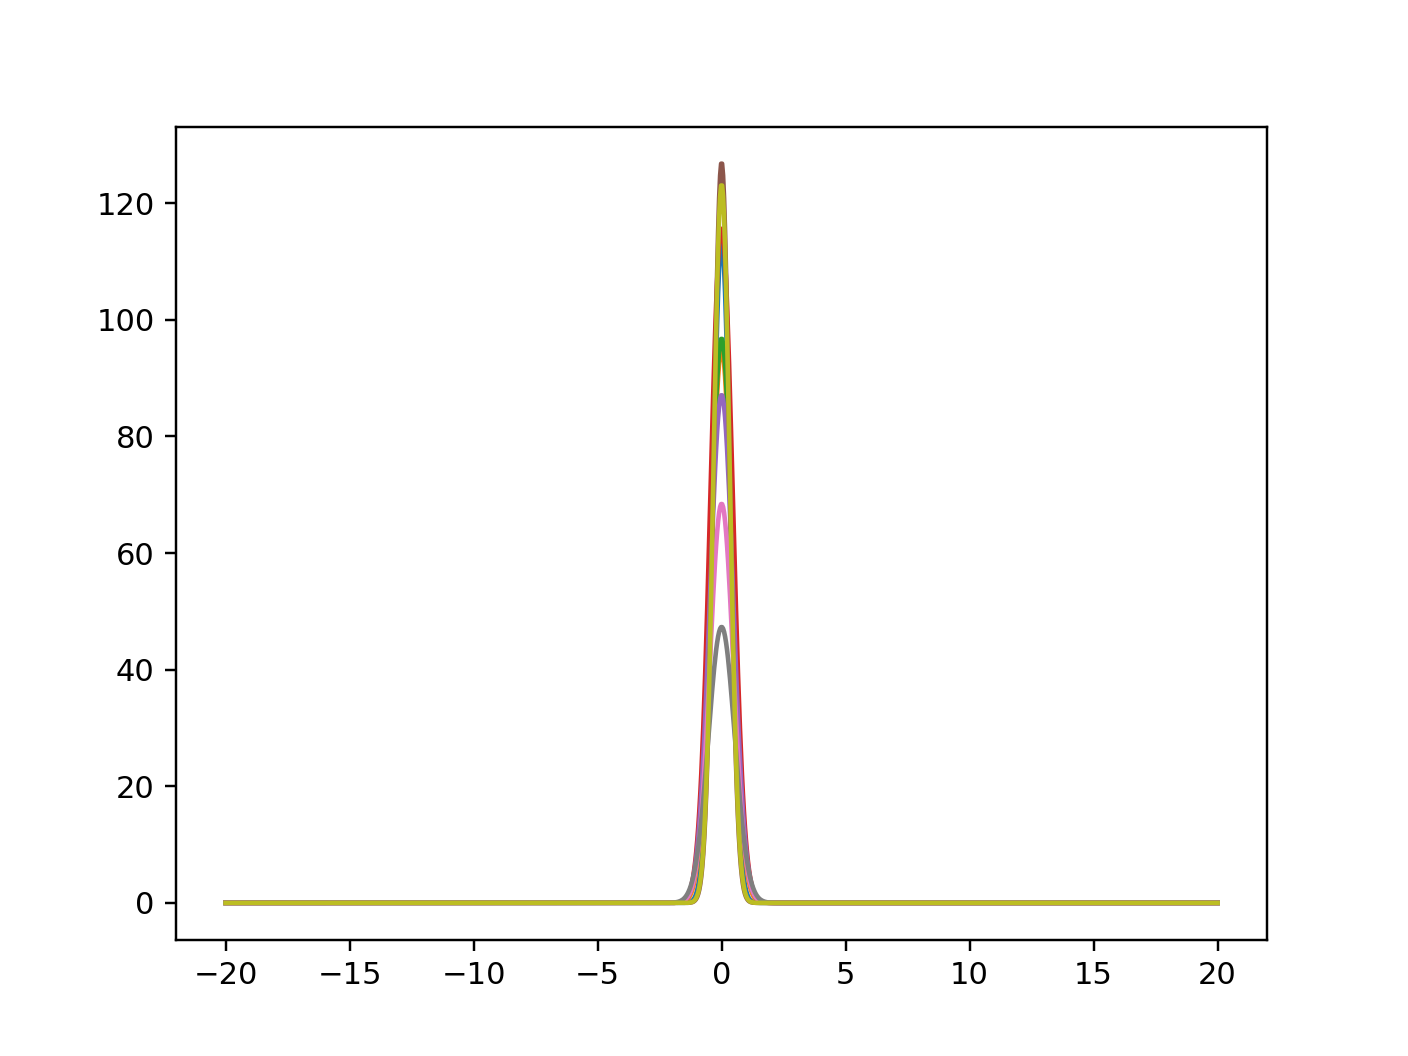

In [38]:
pl.figure()
for i in range(9):
    pl.plot(x,gauss_profile[:,i],label='gauss')

In [ ]:
#code to make/save colormaps

pl.figure()

cmap = mpimg.imread('/Users/marcoaqil/pycortex/filestore/colormaps/Retinotopy_HSV_2x_alpha.png') 
pl.imshow(np.swapaxes(np.fliplr(cmap),0,1))
pl.ylim((62,193))
pl.xlim((0,3))
pl.gca().axes.get_xaxis().set_visible(False)
pl.gca().set_yticks(np.linspace(62,193,5))
pl.gca().set_yticklabels(('$-\pi/2$','$-3\pi/4$','$\pi$','$3\pi/4$','$\pi/2$'))
pl.savefig('/Users/marcoaqil/PRFMapping/Figures/polr_cmap.png', dpi=200, bbox_inches='tight', transparent=True)

pl.figure()

cmap = mpimg.imread('/Users/marcoaqil/pycortex/filestore/colormaps/Jet_2D_alpha.png') 
pl.imshow(np.swapaxes(np.fliplr(cmap),0,1))
pl.xlim((0,5))
pl.gca().axes.get_xaxis().set_visible(False)
pl.gca().set_yticks([255,3*255/3.75,2*255/3.75,1*255/3.75,0])
pl.gca().set_yticklabels(('$0.25\degree$', '$1\degree$', '$2\degree$','$3\degree$','$4\degree$'))
pl.savefig('/Users/marcoaqil/PRFMapping/Figures/ecc_cmap.png', dpi=200, bbox_inches='tight', transparent=True)

pl.figure()

cmap = mpimg.imread('/Users/marcoaqil/pycortex/filestore/colormaps/Jet_2D_alpha.png') 
pl.imshow(np.swapaxes(np.fliplr(cmap),0,1))
pl.xlim((0,5))
pl.gca().axes.get_xaxis().set_visible(False)
pl.gca().set_yticks(np.linspace(255,0,5))
pl.gca().set_yticklabels(np.linspace(0,200,5).astype('int'))
pl.savefig('/Users/marcoaqil/PRFMapping/Figures/Bparam_cmap.png', dpi=200, bbox_inches='tight', transparent=True)

<IPython.core.display.Javascript object>


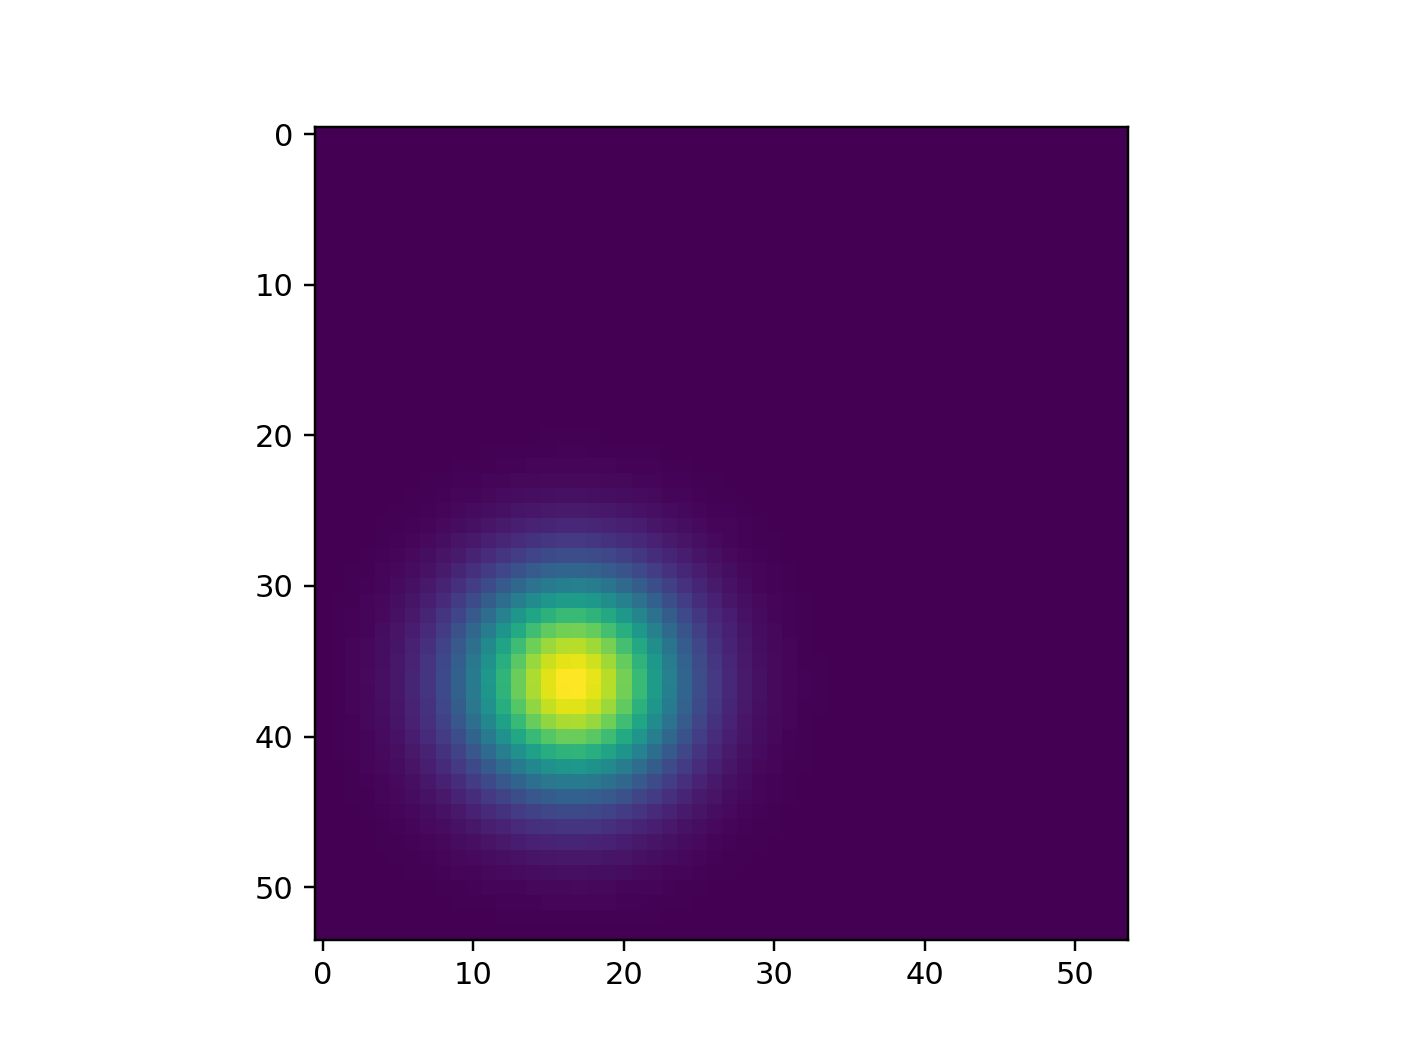

In [74]:
from prfpy.rf import gauss2D_iso_cart
from prfpy.timecourse import stimulus_through_prf
dm = gg.stimulus.design_matrix

rf = np.rot90(gauss2D_iso_cart(x=gg.stimulus.x_coordinates[..., np.newaxis],
                              y=gg.stimulus.y_coordinates[..., np.newaxis],
                              mu=(-2, -2),
                              sigma=1,
                              normalize_RFs=False).T, axes=(1,2))
neural_tc = stimulus_through_prf(rf, dm)
pl.figure()
pl.imshow(rf[0])

In [205]:
###############outdated cells

71.42857142857143

In [96]:
#correcting for low intensity TCs (lowest xx percentile per ROI) (unused)
tc_mean_full = np.zeros(nonzerovar_mask.shape)
tc_mean = timecourse.mean(-1)
tc_mean_full[nonzerovar_mask]=tc_mean

for roi in idx_rois:
    k_values = int(len(idx_rois[roi])/20)
    lowest_intensity = np.argpartition(tc_mean_full[idx_rois[roi]][tc_mean_full[idx_rois[roi]]>0], k_values)
    alpha[idx_rois[roi][tc_mean_full[idx_rois[roi]]>0][lowest_intensity[:k_values]]] = 0
    
    tc_mean_full[idx_rois[roi][tc_mean_full[idx_rois[roi]]>0][lowest_intensity[:k_values]]] = 0

#plotting histograms of mean signal intensity per ROI, after removing lowest intensity
for roi in idx_rois:
    pl.figure()
    pl.title(roi)
    pl.hist(tc_mean_full[idx_rois[roi]],bins=100)
    pl.show()
    #pl.close()

In [2]:
#load data fsaverage sub 001

gauss = np.load("/Users/marcoaqil/PRFMapping/Cartesius results/sub-001_iterparams-gauss_space-fsaverage.npy")
norm_grid = np.load("/Users/marcoaqil/PRFMapping/Cartesius results/sub-001_gridparams-norm_space-fsaverage.npy") 
norm_an = np.load("/Users/marcoaqil/PRFMapping/Cartesius results/sub-001_iterparams-norm_space-fsaverage_analytic.npy")
#norm_num = np.load("/Users/marcoaqil/PRFMapping/Cartesius results/sub-001_iterparams-norm_space-fsaverage_numerical.npy")
dog_res= np.load("/Users/marcoaqil/PRFMapping/Cartesius results/sub-001_iterparams-dog_space-fsaverage.npy")
css_res= np.load("/Users/marcoaqil/PRFMapping/Cartesius results/sub-001_iterparams-css_space-fsaverage.npy")
norm_unbound = np.load("/Users/marcoaqil/PRFMapping/Cartesius results/sub-001_iterparams-norm_space-fsaverage_unbounded.npy")
norm_combined=np.load("/Users/marcoaqil/PRFMapping/Cartesius results/sub-001_norm-iterparams-combined_space-fsaverage.npy")
norm_powell=np.load("/Users/marcoaqil/PRFMapping/Cartesius results sub-001/sub-001_iterparams-norm_space-fsaverage_powell.npy")
norm_num_fix = np.load("/Users/marcoaqil/PRFMapping/Cartesius results/sub-001_iterparams-norm_space-fsaverage_num_bounds_fixed.npy")

nonzerovar_mask = np.load("/Users/marcoaqil/PRFMapping/sub-001_nonzerovar-mask_space-fsaverage.npy")

norm_res = norm_num_fix

#load data fsnative sub 001
gauss = np.load("/Users/marcoaqil/PRFMapping/Cartesius results/sub-001_iterparams-gauss_space-fsnative.npy")
css_res= np.load("/Users/marcoaqil/PRFMapping/Cartesius results/sub-001_iterparams-css_space-fsnative.npy")
dog_res= np.load("/Users/marcoaqil/PRFMapping/Cartesius results/sub-001_iterparams-dog_space-fsnative.npy")
norm_res = np.load("/Users/marcoaqil/PRFMapping/Cartesius results/sub-001_iterparams-norm_space-fsnative.npy")
nonzerovar_mask = np.load("/Users/marcoaqil/PRFMapping/Cartesius results/sub-001_nonzerovar-mask_space-fsnative.npy")
timecourse = np.load('/Users/marcoaqil/PRFMapping/Cartesius results/sub-001_timecourse_space-fsnative.npy')

#load data fsnative sub 006 (old)
gauss = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-006_iterparams-gauss_space-fsnative.npy")
css_res= np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-006_iterparams-css_space-fsnative.npy")
dog_res= np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-006_iterparams-dog_space-fsnative.npy")
norm_res = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-006_iterparams-norm_space-fsnative.npy")
norm_grid = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-006_gridparams-norm_space-fsnative.npy")
gauss_grid = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-006_gridparams-gauss_space-fsnative.npy")

nonzerovar_mask = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-006_nonlow-var-mask_space-fsnative.npy")

timecourse = np.load('/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-006_timecourse_space-fsnative.npy')

#load data fsnative20191107120858 sub 006 SMALLER BOUNDS iterated fit (old)
gauss_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/smaller_bounds/sub-006_iterparams-gauss_space-fsnative20191107120858.npy")
css_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/smaller_bounds/sub-006_iterparams-css_space-fsnative20191107120858.npy")
dog_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/smaller_bounds/sub-006_iterparams-dog_space-fsnative20191107120858.npy")
norm_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/smaller_bounds/sub-006_iterparams-norm_space-fsnative20191107120858.npy")

nonzerovar_mask = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/smaller_bounds/sub-006_nonlow-var-mask_space-fsnative.npy")

timecourse = np.load('/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/smaller_bounds/sub-006_timecourse_space-fsnative.npy')

#load data fsnative sub 006 iterated with trust-constr minimizer (old)
gauss_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-006_iterparams-gauss_space-fsnative20191106094038.npy")
css_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-006_iterparams-css_space-fsnative20191106094038.npy")
dog_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-006_iterparams-dog_space-fsnative20191106094038.npy")
norm_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-006_iterparams-norm_space-fsnative20191106094038.npy")

#nonzerovar_mask_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-006_nonlow-var-mask_space-fsnative.npy")

#timecourse_it = np.load('/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-006_timecourse_space-fsnative.npy')

#load data fsnative sub 006 first surr constraints tc first (old)
gauss = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/surr_constraints_tc_first/sub-006_iterparams-gauss_space-fsnative.npy")
css_res = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/surr_constraints_tc_first/sub-006_iterparams-css_space-fsnative.npy")
dog_res = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/surr_constraints_tc_first/sub-006_iterparams-dog_space-fsnative.npy")
norm_res = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/surr_constraints_tc_first/sub-006_iterparams-norm_space-fsnative.npy")

#load data fsnative sub 006 first surr constraints tc first iterated (old)
gauss_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/surr_constraints_tc_first/sub-006_iterparams-gauss_space-fsnative20191108021600.npy")
css_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/surr_constraints_tc_first/sub-006_iterparams-css_space-fsnative20191108021600.npy")
dog_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/surr_constraints_tc_first/sub-006_iterparams-dog_space-fsnative20191108021600.npy")
norm_res_it = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/surr_constraints_tc_first/sub-006_iterparams-norm_space-fsnative20191108021600.npy")

#load data fsnative sub 007 (old)
gauss = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-007_iterparams-gauss_space-fsnative.npy")
css_res = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-007_iterparams-css_space-fsnative.npy")
dog_res = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-007_iterparams-dog_space-fsnative.npy")
norm_res = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-007_iterparams-norm_space-fsnative.npy")
norm_grid = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-007_gridparams-norm_space-fsnative.npy")
gauss_grid = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-007_gridparams-gauss_space-fsnative.npy")

nonzerovar_mask = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-007_nonlow-var-mask_space-fsnative.npy")
timecourse = np.load('/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/sub-007_timecourse_space-fsnative.npy')

In [ ]:
#plot suppr idx on cortex (not very meaningful)
#suppression index (for norm also take into account baseline?)
suppr_idx = np.zeros((nonzerovar_mask.shape[0],2))
suppr_idx[nonzerovar_mask,0] = (dog_res[:,5] * dog_res[:,6]**2)/(dog_res[:,3] * dog_res[:,2]**2)
suppr_idx[nonzerovar_mask,1] = (norm_res[:,5] * norm_res[:,6]**2 + norm_res[:,7])/(norm_res[:,3] * norm_res[:,2]**2 + norm_res[:,8])

suppr_idx_dog = cortex.Vertex2D(np.log(suppr_idx[:,0]), alpha, subject=subj,
                                vmin=-25, vmax=10, vmin2=0.2, vmax2=0.6, cmap='Jet_2D_alpha')
suppr_idx_norm = cortex.Vertex2D(np.log(suppr_idx[:,1]), alpha, subject=subj,
                                 vmin=-12, vmax=2, vmin2=0.2, vmax2=0.6, cmap='Jet_2D_alpha')

ds_suppr_idx = {'suppr_idx DoG':suppr_idx_dog.raw, 'suppr_idx Norm':suppr_idx_norm.raw}

cortex.webgl.show(ds_suppr_idx,
                 with_curvature=True, 
                 with_labels=True, 
                 with_rois=True, 
                 with_borders=True, 
                 with_colorbar=True)

In [302]:
#load data sub 006 mean 100 tc fit (with normalized RFs)
normalize_RFs = True
subj='sub-006'
space = 'fsnative'

gauss_grid, norm_grid, gauss, css_res, dog_res, norm_res = combine_results(
        '/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/normalizedRFs', subj, space,
        ['2019-11-20-14-33-34', '2019-11-21-21-08-07',
         '2019-11-21-10-32-09', '2019-11-21-09-23-30'])

#timecourse and mask (from before)
nonzerovar_mask = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/mean_100_tc/sub-006_mask_space-fsnative.npy")
timecourse = np.load('/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/mean_100_tc/sub-006_timecourse_space-fsnative.npy')

In [7]:
%%capture

#RSQ
rsq = np.zeros((nonzerovar_mask.shape[0],4))
rsq[nonzerovar_mask,0] = gauss[:,-1]
rsq[nonzerovar_mask,1] = css_res[:, -1]
rsq[nonzerovar_mask,2] = dog_res[:, -1]
rsq[nonzerovar_mask,3] = norm_res[:, -1]

#prf ecc
ecc = np.zeros((nonzerovar_mask.shape[0],4))
ecc[nonzerovar_mask,0] = np.sqrt(gauss[:,0]**2+gauss[:,1]**2)
ecc[nonzerovar_mask,1] = np.sqrt(css_res[:,0]**2+css_res[:,1]**2)
ecc[nonzerovar_mask,2] = np.sqrt(dog_res[:,0]**2+dog_res[:,1]**2)
ecc[nonzerovar_mask,3] = np.sqrt(norm_res[:,0]**2+norm_res[:,1]**2)

#prf polar angle
polar = np.zeros((nonzerovar_mask.shape[0],4))
polar[nonzerovar_mask,0] = np.arctan2(-gauss[:,0], gauss[:,1])
polar[nonzerovar_mask,1] = np.arctan2(-css_res[:,0], css_res[:,1])
polar[nonzerovar_mask,2] = np.arctan2(-dog_res[:,0], dog_res[:,1])
polar[nonzerovar_mask,3] = np.arctan2(-norm_res[:,0], norm_res[:,1])

#prf size
size = np.zeros((nonzerovar_mask.shape[0],4))
size[nonzerovar_mask,0] = gauss[:,2]
size[nonzerovar_mask,1] = css_res[:,2]
size[nonzerovar_mask,2] = dog_res[:,2]
size[nonzerovar_mask,3] = norm_res[:,2]

#prf amplitude
amp = np.zeros((nonzerovar_mask.shape[0],4))
amp[nonzerovar_mask,0] = gauss[:,3]
amp[nonzerovar_mask,1] = css_res[:,3]
amp[nonzerovar_mask,2] = dog_res[:,3]
amp[nonzerovar_mask,3] = norm_res[:,3]

#BOLD baseline
bold_base = np.zeros((nonzerovar_mask.shape[0],4))
bold_base[nonzerovar_mask,0] = gauss[:,4]
bold_base[nonzerovar_mask,1] = css_res[:,4]
bold_base[nonzerovar_mask,2] = dog_res[:,4]
bold_base[nonzerovar_mask,3] = norm_res[:,4]

#css exponent
css_exp = np.zeros(nonzerovar_mask.shape[0])
css_exp[nonzerovar_mask] = css_res[:,5]

#surround amplitude
surr_amp = np.zeros((nonzerovar_mask.shape[0],2))
surr_amp[nonzerovar_mask,0] = dog_res[:,5]
surr_amp[nonzerovar_mask,1] = norm_res[:,5]

#surround size
surr_size = np.zeros((nonzerovar_mask.shape[0],2))
surr_size[nonzerovar_mask,0] = dog_res[:,6]
surr_size[nonzerovar_mask,1] = norm_res[:,6]

#normalization model baselines (neural and surround, ratio, (a+b/(c+d), ad-bc))
baselines = np.zeros((nonzerovar_mask.shape[0],5))
baselines[nonzerovar_mask,0] = norm_res[:,7]
baselines[nonzerovar_mask,1] = norm_res[:,8]
baselines[nonzerovar_mask,2] = norm_res[:,7]/norm_res[:,8]
baselines[nonzerovar_mask,3] = (norm_res[:,3]+norm_res[:,7])/(norm_res[:,5]+norm_res[:,8])
baselines[nonzerovar_mask,4] = (norm_res[:,3]*norm_res[:,8])-(norm_res[:,5]*norm_res[:,7])

#fwhmax fwatmin
fw_hmax = np.zeros((nonzerovar_mask.shape[0],4))
fw_atmin = np.zeros((nonzerovar_mask.shape[0],2))
norm_profiles = np.zeros((1000, nonzerovar_mask.shape[0]))
fw_hmax[nonzerovar_mask,0] = fwhmax_fwatmin('Gauss', gauss, normalize_RFs)
fw_hmax[nonzerovar_mask,1] = fwhmax_fwatmin('CSS', css_res, normalize_RFs)
fw_hmax[nonzerovar_mask,2], fw_atmin[nonzerovar_mask,0] = fwhmax_fwatmin('DoG', dog_res, normalize_RFs)
(fw_hmax[nonzerovar_mask,3], fw_atmin[nonzerovar_mask,1]), norm_profiles[:,nonzerovar_mask] = fwhmax_fwatmin('Norm', norm_res, normalize_RFs,
                                                                                      return_profiles=True)

In [ ]:
#raw time series stats

tc_mean_dict={}
tc_var_dict={}
tc_tsnr_dict={}

for space in spaces:
    for subj in subjects:
        load timecourse_raw and mask_raw
        
    if subj == 'sub-006':
        timecourse_raw = np.load('/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/smaller_bounds/sub-006_timecourse_space-fsnative.npy')
        mask_raw = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/smaller_bounds/sub-006_nonlow-var-mask_space-fsnative.npy")
    elif subj == 'sub-007':
        mask_raw = np.load("/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/raw_data_fits/sub-007_mask_space-fsnative.npy")
        timecourse_raw = np.load('/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/raw_data_fits/sub-007_timecourse_space-fsnative.npy')
    elif subj == 'sub-001':
        mask_raw = np.load("/Users/marcoaqil/PRFMapping/Cartesius results/sub-001_nonzerovar-mask_space-fsnative.npy")
        timecourse_raw = np.load('/Users/marcoaqil/PRFMapping/Cartesius results/sub-001_timecourse_space-fsnative.npy')

    #calc raw time series mean and plotting histograms of mean signal intensity per ROI
    tc_mean_full = np.zeros(mask_raw.shape)
    tc_mean_full[mask_raw] = timecourse_raw.mean(-1)
    tc_mean_dict[subj] = tc_mean_full
    
    tc_var_full = np.zeros(mask_raw.shape)
    tc_var_full[mask_raw] = timecourse_raw.var(-1)
    tc_var_dict[subj] = tc_var_full
    
    tc_tsnr_full = tc_mean_full/np.sqrt(tc_var_full)  
    tc_tsnr_dict[subj] = tc_tsnr_full
    
    

In [ ]:
norm_params_full = np.zeros((nonzerovar_mask.shape[0],10))
norm_params_full[nonzerovar_mask,:] = np.copy(norm_res)

In [143]:
#output freesurefer-format eccentricity angle maps to draw custom ROIs in freeview
lh_c = read_morph_data(opj(fs_dir, subj+'/surf/lh.curv'))

ecc_freeview = np.median(ecc, axis=-1)

alpha_freeview = rsq.max(-1) * (amp.min(-1)>0) * (tc_mean_full>tc_min) * (ecc.max(-1)<ecc_max) * (ecc.min(-1)>ecc_min)

ecc_freeview[alpha_freeview<0.2] = -10

write_morph_data(opj(fs_dir, subj+'/surf/lh.ecc_masked')
                                       ,ecc_freeview[:lh_c.shape[0]])
write_morph_data(opj(fs_dir, subj+'/surf/rh.ecc_masked')
                                       ,ecc_freeview[lh_c.shape[0]:])

#output freesurefer-format polar angle maps to draw custom ROIs in freeview
lh_c = read_morph_data(opj(fs_dir, subj+'/surf/lh.curv'))

baseline_freeview = baselines[:,0]

alpha_freeview = rsq.max(-1) * (amp.min(-1)>0) * (tc_mean_full>tc_min) * (ecc.max(-1)<ecc_max) * (ecc.min(-1)>ecc_min)

baseline_freeview[alpha_freeview<0.2] = -10

write_morph_data(opj(fs_dir, subj+'/surf/lh.baseline_masked')
                                       ,baseline_freeview[:lh_c.shape[0]])
write_morph_data(opj(fs_dir, subj+'/surf/rh.baseline_masked')
                                       ,baseline_freeview[lh_c.shape[0]:])

In [ ]:
#load data RAW BOLD fit ABC norm model variant (5000tr-con maxiter no constraints)
space = 'fsnative'

main_dict[space]['ABC_raw']['sub-006']['Results'] = combine_results('sub-006', space,
        '/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/raw_data_abc', 
        ['2019-12-02-14-38-20', '2019-12-03-11-03-08',
         '2019-12-03-16-00-08', '2019-12-03-11-45-30'])

main_dict[space]['ABC_raw']['sub-007']['Results'] = combine_results('sub-007', space,
        '/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/raw_data_abc', 
        ['2019-12-02-21-18-45', '2019-12-03-10-46-06',
         '2019-12-03-12-00-44', '2019-12-03-13-23-45'])

#load data MEAN-100-TC fit ABC norm model variant (5000tr-con maxiter. no constraints)
space = 'fsnative'
 
main_dict[space]['ABC_100'][subj]['Results'] = combine_results('sub-006', space,
        '/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/mean_100_ABC_norm', 
        ['2019-11-30-15-34-05', '2019-12-01-11-15-33',
         '2019-12-01-13-01-26', '2019-12-01-15-26-47'])

main_dict[space]['ABC_100']['sub-007']['Results'] = combine_results('sub-007', space,
        '/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/mean_100_ABC_norm',
        ['2019-11-30-15-33-42', '2019-12-01-11-49-31',
         '2019-12-01-13-32-49', '2019-12-01-15-29-24'])

main_dict[space]['ABC_100']['sub-001']['Results'] = combine_results('sub-001', space,
        '/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/mean_100_ABC_norm',
        ['2019-12-04-10-45-12', '2019-12-04-14-03-47',
         '2019-12-04-15-55-17', '2019-12-04-21-03-19'])

#load data mean 100 tc fit (ABCD norm)
space = 'fsnative'

main_dict[space]['Standard_100']['sub-006']['Results'] = combine_results('sub-006', space,
        '/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/mean_100_tc',
        ['2019-11-15-11-36-38', '2019-11-16-08-04-40',
         '2019-11-16-11-05-09', '2019-11-15-15-53-43'])

main_dict[space]['Standard_100']['sub-007']['Results'] = combine_results('sub-007', space,
        '/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/mean_100_tc',
        ['2019-11-27-11-19-09', '2019-11-28-14-22-27',
         '2019-11-29-12-25-38', '2019-11-29-18-00-53'])

#load data raw data fits (ABCD norm)
space = 'fsnative'
 
main_dict[space]['Standard_raw']['sub-006']['Results'] = combine_results('sub-006', space, 
        '/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/raw_data_fits',
        ['20191109165849', '20191110131514',
         '20191109100256', '20191109141507'])
 
main_dict[space]['Standard_raw']['sub-007']['Results'] = combine_results('sub-007', space,
        '/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/raw_data_fits', 
        ['', '20191112083058',
         '20191112180440', '20191113094719'])

main_dict[space]['Standard_raw']['sub-001']['Results'] = combine_results('sub-001', space,
        '/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/prfpy/raw_data_fits', 
        ['2019-11-28-20-50-33', '2019-11-29-14-32-37',
         '2019-11-29-16-10-34', '2019-11-30-11-22-29'])

In [ ]:
#import newly analyzed subject from freesurfer to pycortex database
#this doesnt work anymore. use script in documents folder

cortex.freesurfer.import_subj('sub-006', freesurfer_subject_dir='/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/freesurfer', 
                              whitematter_surf='smoothwm')

#importing flatmap created with freeview or tksurfer to pycortex database
#cortex.freesurfer.import_flat(subject='sub-006', patch='full', hemis=['lh', 'rh'], 
#                freesurfer_subject_dir='/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-hires/freesurfer', clean=True)

In [311]:
#plotting histograms of tSNR per ROI
#for roi in ["V1","V2","V3"]:
#    pl.figure()
#    pl.title(roi)
#    pl.hist(tsnr_full[idx_rois[roi]],bins=100)
#    pl.show()
#    pl.close()

# different views available, more views can be added  and the
# existing list can be removed
#views = dict(lateral=dict(radius=250, altitude=90.5, azimuth=181, pivot=180),
#             medial=dict(radius=10, altitude=90.5, azimuth=0, pivot=180),
#             front=dict(radius=250, altitude=90.5, azimuth=0, pivot=0),
#             back=dict(radius=250, altitude=90.5, azimuth=181, pivot=0),
#             top=dict(radius=250, altitude=0, azimuth=180, pivot=0),
#             bottom=dict(radius=250, altitude=180, azimuth=0, pivot=0)
#            )